In [1]:
import torch

# Local imports
from train import train_model

Using device: cpu


In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [3]:
args = {
    "use_small_dataset": False,
    "batch_size": 64,
    "stoppage_epochs": 64,
    "max_epochs": 512,
    "seed": 0,
    "data_path": "../data",
    "frac_train": 0.8,
    "frac_validation": 0.1,
    "frac_test": 0.1,
    "huber_beta": 0.5,
    "weight_decay": 1e-3,
    "lr": 3e-4,
    "scheduler_patience": 10,
    "scheduler_factor": 0.5,
    "hidden_size": 96,
    "num_layers": 8,
    "num_attn_heads": 6,
    "dropout": 0.2,
    "pooling_dropout": 0.1,
    "pooling_dim": 96,
}

Model parameters: 201843


Epoch 1/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [02:13<00:00,  6.76it/s]


Epoch 1/512: 
Train Loss = 0.78773, Train MSE = 1.54009, Train MAE = 1.01348, Train Acc = 0.55331
Val Loss = 0.70925, Val MSE = 1.30583, Val MAE = 0.93279, Val Acc = 0.59216


Epoch 2/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:44<00:00, 20.28it/s]


Epoch 2/512: 
Train Loss = 0.72789, Train MSE = 1.36793, Train MAE = 0.95133, Train Acc = 0.58714
Val Loss = 0.70115, Val MSE = 1.28509, Val MAE = 0.92355, Val Acc = 0.59478


Epoch 3/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.10it/s]


Epoch 3/512: 
Train Loss = 0.71698, Train MSE = 1.33652, Train MAE = 0.94002, Train Acc = 0.59311
Val Loss = 0.70397, Val MSE = 1.28961, Val MAE = 0.92631, Val Acc = 0.59699


Epoch 4/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 4/512: 
Train Loss = 0.71010, Train MSE = 1.31565, Train MAE = 0.93320, Train Acc = 0.59587
Val Loss = 0.69966, Val MSE = 1.27931, Val MAE = 0.92239, Val Acc = 0.59699


Epoch 5/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.03it/s]


Epoch 5/512: 
Train Loss = 0.69253, Train MSE = 1.27366, Train MAE = 0.91464, Train Acc = 0.60671
Val Loss = 0.67522, Val MSE = 1.22210, Val MAE = 0.89628, Val Acc = 0.61963


Epoch 6/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 6/512: 
Train Loss = 0.68750, Train MSE = 1.26053, Train MAE = 0.90969, Train Acc = 0.61011
Val Loss = 0.67143, Val MSE = 1.21272, Val MAE = 0.89307, Val Acc = 0.61949


Epoch 7/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.04it/s]


Epoch 7/512: 
Train Loss = 0.67906, Train MSE = 1.24059, Train MAE = 0.90000, Train Acc = 0.61387
Val Loss = 0.65964, Val MSE = 1.18051, Val MAE = 0.88073, Val Acc = 0.62847


Epoch 8/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.04it/s]


Epoch 8/512: 
Train Loss = 0.67262, Train MSE = 1.22302, Train MAE = 0.89365, Train Acc = 0.61984
Val Loss = 0.65287, Val MSE = 1.16929, Val MAE = 0.87346, Val Acc = 0.63109


Epoch 9/512: 100%|██████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.08it/s]


Epoch 9/512: 
Train Loss = 0.66701, Train MSE = 1.21089, Train MAE = 0.88788, Train Acc = 0.62310
Val Loss = 0.64975, Val MSE = 1.15989, Val MAE = 0.87071, Val Acc = 0.63565


Epoch 10/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 10/512: 
Train Loss = 0.66167, Train MSE = 1.19824, Train MAE = 0.88229, Train Acc = 0.62679
Val Loss = 0.63797, Val MSE = 1.13344, Val MAE = 0.85857, Val Acc = 0.64559


Epoch 11/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.06it/s]


Epoch 11/512: 
Train Loss = 0.65686, Train MSE = 1.18825, Train MAE = 0.87746, Train Acc = 0.63213
Val Loss = 0.63356, Val MSE = 1.12623, Val MAE = 0.85394, Val Acc = 0.64656


Epoch 12/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 12/512: 
Train Loss = 0.65116, Train MSE = 1.17517, Train MAE = 0.87107, Train Acc = 0.63368
Val Loss = 0.63582, Val MSE = 1.12771, Val MAE = 0.85648, Val Acc = 0.64297


Epoch 13/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 13/512: 
Train Loss = 0.64499, Train MSE = 1.15923, Train MAE = 0.86492, Train Acc = 0.63872
Val Loss = 0.62653, Val MSE = 1.10832, Val MAE = 0.84702, Val Acc = 0.65042


Epoch 14/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 14/512: 
Train Loss = 0.64252, Train MSE = 1.15533, Train MAE = 0.86192, Train Acc = 0.64091
Val Loss = 0.61769, Val MSE = 1.08391, Val MAE = 0.83764, Val Acc = 0.66036


Epoch 15/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 15/512: 
Train Loss = 0.63654, Train MSE = 1.14304, Train MAE = 0.85551, Train Acc = 0.64479
Val Loss = 0.61048, Val MSE = 1.07291, Val MAE = 0.82962, Val Acc = 0.66050


Epoch 16/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 16/512: 
Train Loss = 0.63337, Train MSE = 1.13431, Train MAE = 0.85203, Train Acc = 0.64618
Val Loss = 0.60489, Val MSE = 1.05310, Val MAE = 0.82416, Val Acc = 0.66229


Epoch 17/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 17/512: 
Train Loss = 0.62754, Train MSE = 1.12005, Train MAE = 0.84624, Train Acc = 0.65071
Val Loss = 0.59459, Val MSE = 1.03378, Val MAE = 0.81251, Val Acc = 0.67444


Epoch 18/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 18/512: 
Train Loss = 0.62272, Train MSE = 1.10975, Train MAE = 0.84072, Train Acc = 0.65486
Val Loss = 0.59884, Val MSE = 1.04775, Val MAE = 0.81639, Val Acc = 0.67334


Epoch 19/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 19/512: 
Train Loss = 0.61723, Train MSE = 1.09728, Train MAE = 0.83531, Train Acc = 0.65986
Val Loss = 0.58617, Val MSE = 1.01598, Val MAE = 0.80333, Val Acc = 0.68287


Epoch 20/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 20/512: 
Train Loss = 0.61498, Train MSE = 1.09156, Train MAE = 0.83274, Train Acc = 0.65976
Val Loss = 0.57986, Val MSE = 0.99940, Val MAE = 0.79646, Val Acc = 0.68659


Epoch 21/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.06it/s]


Epoch 21/512: 
Train Loss = 0.61302, Train MSE = 1.08697, Train MAE = 0.83095, Train Acc = 0.66207
Val Loss = 0.58106, Val MSE = 1.00933, Val MAE = 0.79763, Val Acc = 0.68204


Epoch 22/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 22/512: 
Train Loss = 0.60775, Train MSE = 1.07516, Train MAE = 0.82516, Train Acc = 0.66628
Val Loss = 0.58070, Val MSE = 1.00481, Val MAE = 0.79718, Val Acc = 0.68287


Epoch 23/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 23/512: 
Train Loss = 0.60499, Train MSE = 1.06873, Train MAE = 0.82210, Train Acc = 0.66871
Val Loss = 0.57016, Val MSE = 0.98392, Val MAE = 0.78625, Val Acc = 0.69488


Epoch 24/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 24/512: 
Train Loss = 0.60063, Train MSE = 1.06129, Train MAE = 0.81729, Train Acc = 0.67187
Val Loss = 0.56612, Val MSE = 0.97426, Val MAE = 0.78055, Val Acc = 0.69350


Epoch 25/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 25/512: 
Train Loss = 0.59883, Train MSE = 1.05848, Train MAE = 0.81571, Train Acc = 0.67379
Val Loss = 0.56162, Val MSE = 0.96549, Val MAE = 0.77616, Val Acc = 0.69281


Epoch 26/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 26/512: 
Train Loss = 0.59292, Train MSE = 1.04333, Train MAE = 0.80932, Train Acc = 0.67721
Val Loss = 0.56654, Val MSE = 0.97968, Val MAE = 0.78084, Val Acc = 0.69377


Epoch 27/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 27/512: 
Train Loss = 0.59191, Train MSE = 1.04180, Train MAE = 0.80819, Train Acc = 0.67802
Val Loss = 0.56323, Val MSE = 0.96945, Val MAE = 0.77820, Val Acc = 0.69778


Epoch 28/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 28/512: 
Train Loss = 0.59074, Train MSE = 1.03707, Train MAE = 0.80719, Train Acc = 0.67898
Val Loss = 0.55159, Val MSE = 0.93609, Val MAE = 0.76675, Val Acc = 0.70509


Epoch 29/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 29/512: 
Train Loss = 0.58691, Train MSE = 1.02732, Train MAE = 0.80307, Train Acc = 0.68010
Val Loss = 0.55917, Val MSE = 0.95561, Val MAE = 0.77474, Val Acc = 0.70026


Epoch 30/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 30/512: 
Train Loss = 0.58293, Train MSE = 1.02217, Train MAE = 0.79856, Train Acc = 0.68268
Val Loss = 0.54696, Val MSE = 0.92677, Val MAE = 0.76210, Val Acc = 0.70758


Epoch 31/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 31/512: 
Train Loss = 0.58335, Train MSE = 1.02179, Train MAE = 0.79903, Train Acc = 0.68193
Val Loss = 0.55760, Val MSE = 0.95156, Val MAE = 0.77258, Val Acc = 0.70026


Epoch 32/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 32/512: 
Train Loss = 0.58070, Train MSE = 1.01591, Train MAE = 0.79626, Train Acc = 0.68578
Val Loss = 0.54020, Val MSE = 0.91469, Val MAE = 0.75410, Val Acc = 0.71048


Epoch 33/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 33/512: 
Train Loss = 0.57729, Train MSE = 1.00632, Train MAE = 0.79320, Train Acc = 0.68689
Val Loss = 0.56243, Val MSE = 0.96112, Val MAE = 0.77777, Val Acc = 0.69460


Epoch 34/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 34/512: 
Train Loss = 0.57795, Train MSE = 1.01239, Train MAE = 0.79330, Train Acc = 0.68742
Val Loss = 0.54555, Val MSE = 0.92986, Val MAE = 0.75920, Val Acc = 0.70703


Epoch 35/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 35/512: 
Train Loss = 0.57484, Train MSE = 1.00044, Train MAE = 0.79037, Train Acc = 0.68884
Val Loss = 0.53904, Val MSE = 0.90979, Val MAE = 0.75249, Val Acc = 0.71338


Epoch 36/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 36/512: 
Train Loss = 0.57344, Train MSE = 1.00041, Train MAE = 0.78905, Train Acc = 0.69232
Val Loss = 0.52986, Val MSE = 0.89180, Val MAE = 0.74254, Val Acc = 0.71655


Epoch 37/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 37/512: 
Train Loss = 0.57033, Train MSE = 0.99340, Train MAE = 0.78545, Train Acc = 0.69436
Val Loss = 0.53421, Val MSE = 0.90312, Val MAE = 0.74769, Val Acc = 0.71255


Epoch 38/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 38/512: 
Train Loss = 0.56888, Train MSE = 0.99033, Train MAE = 0.78386, Train Acc = 0.69358
Val Loss = 0.53658, Val MSE = 0.90502, Val MAE = 0.74984, Val Acc = 0.71131


Epoch 39/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 39/512: 
Train Loss = 0.56819, Train MSE = 0.98685, Train MAE = 0.78325, Train Acc = 0.69560
Val Loss = 0.52854, Val MSE = 0.88404, Val MAE = 0.74216, Val Acc = 0.72208


Epoch 40/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 40/512: 
Train Loss = 0.56639, Train MSE = 0.98547, Train MAE = 0.78099, Train Acc = 0.69564
Val Loss = 0.52610, Val MSE = 0.88715, Val MAE = 0.73848, Val Acc = 0.72180


Epoch 41/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 41/512: 
Train Loss = 0.56375, Train MSE = 0.97695, Train MAE = 0.77858, Train Acc = 0.69647
Val Loss = 0.53283, Val MSE = 0.89516, Val MAE = 0.74634, Val Acc = 0.71586


Epoch 42/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 42/512: 
Train Loss = 0.56501, Train MSE = 0.97955, Train MAE = 0.78003, Train Acc = 0.69634
Val Loss = 0.52862, Val MSE = 0.88831, Val MAE = 0.74192, Val Acc = 0.72042


Epoch 43/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 43/512: 
Train Loss = 0.56196, Train MSE = 0.97216, Train MAE = 0.77652, Train Acc = 0.69962
Val Loss = 0.52356, Val MSE = 0.87715, Val MAE = 0.73581, Val Acc = 0.72622


Epoch 44/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 44/512: 
Train Loss = 0.56016, Train MSE = 0.96951, Train MAE = 0.77431, Train Acc = 0.69812
Val Loss = 0.53020, Val MSE = 0.89431, Val MAE = 0.74245, Val Acc = 0.71945


Epoch 45/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 45/512: 
Train Loss = 0.55689, Train MSE = 0.96187, Train MAE = 0.77101, Train Acc = 0.70161
Val Loss = 0.52826, Val MSE = 0.89509, Val MAE = 0.74062, Val Acc = 0.72373


Epoch 46/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 46/512: 
Train Loss = 0.55690, Train MSE = 0.96197, Train MAE = 0.77112, Train Acc = 0.70133
Val Loss = 0.53761, Val MSE = 0.90585, Val MAE = 0.75132, Val Acc = 0.70993


Epoch 47/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 47/512: 
Train Loss = 0.55533, Train MSE = 0.95814, Train MAE = 0.76947, Train Acc = 0.70306
Val Loss = 0.52139, Val MSE = 0.87172, Val MAE = 0.73342, Val Acc = 0.72401


Epoch 48/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 48/512: 
Train Loss = 0.55203, Train MSE = 0.95219, Train MAE = 0.76576, Train Acc = 0.70663
Val Loss = 0.51852, Val MSE = 0.86192, Val MAE = 0.73153, Val Acc = 0.72649


Epoch 49/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 49/512: 
Train Loss = 0.55243, Train MSE = 0.95186, Train MAE = 0.76662, Train Acc = 0.70615
Val Loss = 0.51350, Val MSE = 0.84845, Val MAE = 0.72668, Val Acc = 0.73478


Epoch 50/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 50/512: 
Train Loss = 0.54676, Train MSE = 0.93971, Train MAE = 0.76002, Train Acc = 0.70965
Val Loss = 0.51002, Val MSE = 0.85230, Val MAE = 0.72145, Val Acc = 0.73423


Epoch 51/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 51/512: 
Train Loss = 0.55080, Train MSE = 0.94597, Train MAE = 0.76500, Train Acc = 0.70594
Val Loss = 0.51141, Val MSE = 0.85417, Val MAE = 0.72330, Val Acc = 0.73257


Epoch 52/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 52/512: 
Train Loss = 0.54853, Train MSE = 0.94186, Train MAE = 0.76270, Train Acc = 0.70934
Val Loss = 0.51055, Val MSE = 0.84378, Val MAE = 0.72260, Val Acc = 0.73022


Epoch 53/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 53/512: 
Train Loss = 0.54642, Train MSE = 0.93660, Train MAE = 0.76005, Train Acc = 0.70853
Val Loss = 0.50262, Val MSE = 0.82739, Val MAE = 0.71430, Val Acc = 0.73519


Epoch 54/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.03it/s]


Epoch 54/512: 
Train Loss = 0.54632, Train MSE = 0.93809, Train MAE = 0.76008, Train Acc = 0.71193
Val Loss = 0.50513, Val MSE = 0.83561, Val MAE = 0.71664, Val Acc = 0.73616


Epoch 55/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 55/512: 
Train Loss = 0.54318, Train MSE = 0.92994, Train MAE = 0.75680, Train Acc = 0.71212
Val Loss = 0.50381, Val MSE = 0.83495, Val MAE = 0.71565, Val Acc = 0.73671


Epoch 56/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 56/512: 
Train Loss = 0.54221, Train MSE = 0.92743, Train MAE = 0.75580, Train Acc = 0.71447
Val Loss = 0.50126, Val MSE = 0.82639, Val MAE = 0.71226, Val Acc = 0.73657


Epoch 57/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 57/512: 
Train Loss = 0.54336, Train MSE = 0.93063, Train MAE = 0.75707, Train Acc = 0.71286
Val Loss = 0.50725, Val MSE = 0.83571, Val MAE = 0.71909, Val Acc = 0.73588


Epoch 58/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 58/512: 
Train Loss = 0.54167, Train MSE = 0.92769, Train MAE = 0.75523, Train Acc = 0.71405
Val Loss = 0.50259, Val MSE = 0.83765, Val MAE = 0.71373, Val Acc = 0.74154


Epoch 59/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 59/512: 
Train Loss = 0.54142, Train MSE = 0.92691, Train MAE = 0.75494, Train Acc = 0.71459
Val Loss = 0.49925, Val MSE = 0.82771, Val MAE = 0.70914, Val Acc = 0.74361


Epoch 60/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 60/512: 
Train Loss = 0.53983, Train MSE = 0.92070, Train MAE = 0.75327, Train Acc = 0.71464
Val Loss = 0.50238, Val MSE = 0.82066, Val MAE = 0.71484, Val Acc = 0.73657


Epoch 61/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 61/512: 
Train Loss = 0.53783, Train MSE = 0.91872, Train MAE = 0.75082, Train Acc = 0.71476
Val Loss = 0.49895, Val MSE = 0.82485, Val MAE = 0.71070, Val Acc = 0.74500


Epoch 62/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 62/512: 
Train Loss = 0.53700, Train MSE = 0.91839, Train MAE = 0.74981, Train Acc = 0.71638
Val Loss = 0.51105, Val MSE = 0.84518, Val MAE = 0.72306, Val Acc = 0.73160


Epoch 63/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 63/512: 
Train Loss = 0.53290, Train MSE = 0.90724, Train MAE = 0.74601, Train Acc = 0.71976
Val Loss = 0.48830, Val MSE = 0.80649, Val MAE = 0.69805, Val Acc = 0.75162


Epoch 64/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 64/512: 
Train Loss = 0.53411, Train MSE = 0.91180, Train MAE = 0.74706, Train Acc = 0.71921
Val Loss = 0.49739, Val MSE = 0.81681, Val MAE = 0.70959, Val Acc = 0.74016


Epoch 65/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 65/512: 
Train Loss = 0.53437, Train MSE = 0.90972, Train MAE = 0.74780, Train Acc = 0.72021
Val Loss = 0.49469, Val MSE = 0.81885, Val MAE = 0.70471, Val Acc = 0.74941


Epoch 66/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 66/512: 
Train Loss = 0.53293, Train MSE = 0.90898, Train MAE = 0.74602, Train Acc = 0.72137
Val Loss = 0.48781, Val MSE = 0.80440, Val MAE = 0.69791, Val Acc = 0.74928


Epoch 67/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 67/512: 
Train Loss = 0.53315, Train MSE = 0.90748, Train MAE = 0.74598, Train Acc = 0.71923
Val Loss = 0.48849, Val MSE = 0.81379, Val MAE = 0.69834, Val Acc = 0.75632


Epoch 68/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 68/512: 
Train Loss = 0.53060, Train MSE = 0.90184, Train MAE = 0.74338, Train Acc = 0.72282
Val Loss = 0.49412, Val MSE = 0.81981, Val MAE = 0.70406, Val Acc = 0.74403


Epoch 69/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 69/512: 
Train Loss = 0.52784, Train MSE = 0.89699, Train MAE = 0.74023, Train Acc = 0.72354
Val Loss = 0.49259, Val MSE = 0.80969, Val MAE = 0.70305, Val Acc = 0.74334


Epoch 70/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 70/512: 
Train Loss = 0.52794, Train MSE = 0.89740, Train MAE = 0.74047, Train Acc = 0.72427
Val Loss = 0.50461, Val MSE = 0.83257, Val MAE = 0.71676, Val Acc = 0.73547


Epoch 71/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 71/512: 
Train Loss = 0.52601, Train MSE = 0.89289, Train MAE = 0.73874, Train Acc = 0.72599
Val Loss = 0.49062, Val MSE = 0.80522, Val MAE = 0.70168, Val Acc = 0.74803


Epoch 72/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 72/512: 
Train Loss = 0.52453, Train MSE = 0.88960, Train MAE = 0.73672, Train Acc = 0.72744
Val Loss = 0.49360, Val MSE = 0.81163, Val MAE = 0.70437, Val Acc = 0.74223


Epoch 73/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 73/512: 
Train Loss = 0.52220, Train MSE = 0.88415, Train MAE = 0.73422, Train Acc = 0.72824
Val Loss = 0.48748, Val MSE = 0.79986, Val MAE = 0.69847, Val Acc = 0.75148


Epoch 74/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 74/512: 
Train Loss = 0.52215, Train MSE = 0.88369, Train MAE = 0.73435, Train Acc = 0.72696
Val Loss = 0.47983, Val MSE = 0.78990, Val MAE = 0.68900, Val Acc = 0.75894


Epoch 75/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 75/512: 
Train Loss = 0.52318, Train MSE = 0.88518, Train MAE = 0.73520, Train Acc = 0.72646
Val Loss = 0.48373, Val MSE = 0.79758, Val MAE = 0.69341, Val Acc = 0.75425


Epoch 76/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 76/512: 
Train Loss = 0.52189, Train MSE = 0.88335, Train MAE = 0.73401, Train Acc = 0.72525
Val Loss = 0.48582, Val MSE = 0.80299, Val MAE = 0.69561, Val Acc = 0.75383


Epoch 77/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 77/512: 
Train Loss = 0.52030, Train MSE = 0.87940, Train MAE = 0.73254, Train Acc = 0.73007
Val Loss = 0.48301, Val MSE = 0.79511, Val MAE = 0.69177, Val Acc = 0.75259


Epoch 78/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 78/512: 
Train Loss = 0.51969, Train MSE = 0.87882, Train MAE = 0.73184, Train Acc = 0.72939
Val Loss = 0.47653, Val MSE = 0.78054, Val MAE = 0.68616, Val Acc = 0.76225


Epoch 79/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 79/512: 
Train Loss = 0.51954, Train MSE = 0.87800, Train MAE = 0.73179, Train Acc = 0.72938
Val Loss = 0.48184, Val MSE = 0.79440, Val MAE = 0.69172, Val Acc = 0.75535


Epoch 80/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 80/512: 
Train Loss = 0.51933, Train MSE = 0.87852, Train MAE = 0.73151, Train Acc = 0.73015
Val Loss = 0.47695, Val MSE = 0.78511, Val MAE = 0.68558, Val Acc = 0.75825


Epoch 81/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 81/512: 
Train Loss = 0.51934, Train MSE = 0.87978, Train MAE = 0.73100, Train Acc = 0.72729
Val Loss = 0.48000, Val MSE = 0.78611, Val MAE = 0.69048, Val Acc = 0.75632


Epoch 82/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 82/512: 
Train Loss = 0.51579, Train MSE = 0.87058, Train MAE = 0.72732, Train Acc = 0.73115
Val Loss = 0.48926, Val MSE = 0.81660, Val MAE = 0.69817, Val Acc = 0.75645


Epoch 83/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 83/512: 
Train Loss = 0.51604, Train MSE = 0.87230, Train MAE = 0.72791, Train Acc = 0.73238
Val Loss = 0.48560, Val MSE = 0.79963, Val MAE = 0.69552, Val Acc = 0.75259


Epoch 84/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 84/512: 
Train Loss = 0.51586, Train MSE = 0.86951, Train MAE = 0.72737, Train Acc = 0.73250
Val Loss = 0.48112, Val MSE = 0.78584, Val MAE = 0.69161, Val Acc = 0.75853


Epoch 85/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 85/512: 
Train Loss = 0.51275, Train MSE = 0.86210, Train MAE = 0.72446, Train Acc = 0.73523
Val Loss = 0.47729, Val MSE = 0.78247, Val MAE = 0.68787, Val Acc = 0.76198


Epoch 86/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 86/512: 
Train Loss = 0.51220, Train MSE = 0.86309, Train MAE = 0.72339, Train Acc = 0.73488
Val Loss = 0.47573, Val MSE = 0.77366, Val MAE = 0.68675, Val Acc = 0.76156


Epoch 87/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 87/512: 
Train Loss = 0.51184, Train MSE = 0.86260, Train MAE = 0.72326, Train Acc = 0.73537
Val Loss = 0.47429, Val MSE = 0.77509, Val MAE = 0.68461, Val Acc = 0.76032


Epoch 88/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 88/512: 
Train Loss = 0.51274, Train MSE = 0.86206, Train MAE = 0.72437, Train Acc = 0.73464
Val Loss = 0.48647, Val MSE = 0.80816, Val MAE = 0.69707, Val Acc = 0.75645


Epoch 89/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 89/512: 
Train Loss = 0.51477, Train MSE = 0.86912, Train MAE = 0.72622, Train Acc = 0.73435
Val Loss = 0.46836, Val MSE = 0.76481, Val MAE = 0.67739, Val Acc = 0.76529


Epoch 90/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 90/512: 
Train Loss = 0.51365, Train MSE = 0.86490, Train MAE = 0.72535, Train Acc = 0.73431
Val Loss = 0.47609, Val MSE = 0.77610, Val MAE = 0.68556, Val Acc = 0.75742


Epoch 91/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.04it/s]


Epoch 91/512: 
Train Loss = 0.51234, Train MSE = 0.86227, Train MAE = 0.72395, Train Acc = 0.73474
Val Loss = 0.47727, Val MSE = 0.78398, Val MAE = 0.68694, Val Acc = 0.76004


Epoch 92/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.03it/s]


Epoch 92/512: 
Train Loss = 0.50898, Train MSE = 0.85693, Train MAE = 0.72036, Train Acc = 0.73657
Val Loss = 0.48535, Val MSE = 0.80543, Val MAE = 0.69518, Val Acc = 0.75701


Epoch 93/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 93/512: 
Train Loss = 0.50757, Train MSE = 0.85239, Train MAE = 0.71905, Train Acc = 0.73914
Val Loss = 0.48469, Val MSE = 0.79944, Val MAE = 0.69520, Val Acc = 0.75121


Epoch 94/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.08it/s]


Epoch 94/512: 
Train Loss = 0.50938, Train MSE = 0.85914, Train MAE = 0.72056, Train Acc = 0.73790
Val Loss = 0.47923, Val MSE = 0.78342, Val MAE = 0.68979, Val Acc = 0.75756


Epoch 95/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.09it/s]


Epoch 95/512: 
Train Loss = 0.50692, Train MSE = 0.85259, Train MAE = 0.71797, Train Acc = 0.73918
Val Loss = 0.46266, Val MSE = 0.75634, Val MAE = 0.67111, Val Acc = 0.76695


Epoch 96/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 96/512: 
Train Loss = 0.50667, Train MSE = 0.84969, Train MAE = 0.71763, Train Acc = 0.73799
Val Loss = 0.46934, Val MSE = 0.76692, Val MAE = 0.67773, Val Acc = 0.76446


Epoch 97/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 97/512: 
Train Loss = 0.50602, Train MSE = 0.84968, Train MAE = 0.71685, Train Acc = 0.74104
Val Loss = 0.47220, Val MSE = 0.77366, Val MAE = 0.68051, Val Acc = 0.76281


Epoch 98/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 98/512: 
Train Loss = 0.50491, Train MSE = 0.84576, Train MAE = 0.71573, Train Acc = 0.73956
Val Loss = 0.46429, Val MSE = 0.76086, Val MAE = 0.67179, Val Acc = 0.76888


Epoch 99/512: 100%|█████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 99/512: 
Train Loss = 0.50769, Train MSE = 0.85291, Train MAE = 0.71891, Train Acc = 0.73820
Val Loss = 0.47162, Val MSE = 0.76963, Val MAE = 0.68038, Val Acc = 0.76142


Epoch 100/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 100/512: 
Train Loss = 0.50363, Train MSE = 0.84495, Train MAE = 0.71427, Train Acc = 0.73916
Val Loss = 0.47007, Val MSE = 0.76740, Val MAE = 0.67854, Val Acc = 0.76170


Epoch 101/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 101/512: 
Train Loss = 0.50348, Train MSE = 0.84395, Train MAE = 0.71460, Train Acc = 0.74090
Val Loss = 0.46992, Val MSE = 0.76860, Val MAE = 0.67876, Val Acc = 0.76184


Epoch 102/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 102/512: 
Train Loss = 0.50308, Train MSE = 0.83973, Train MAE = 0.71428, Train Acc = 0.74182
Val Loss = 0.46374, Val MSE = 0.76095, Val MAE = 0.67207, Val Acc = 0.76902


Epoch 103/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 103/512: 
Train Loss = 0.50286, Train MSE = 0.84436, Train MAE = 0.71390, Train Acc = 0.74272
Val Loss = 0.46626, Val MSE = 0.75911, Val MAE = 0.67557, Val Acc = 0.76294


Epoch 104/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 104/512: 
Train Loss = 0.50414, Train MSE = 0.84519, Train MAE = 0.71540, Train Acc = 0.74072
Val Loss = 0.45935, Val MSE = 0.75385, Val MAE = 0.66699, Val Acc = 0.77661


Epoch 105/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 105/512: 
Train Loss = 0.49955, Train MSE = 0.83456, Train MAE = 0.71048, Train Acc = 0.74420
Val Loss = 0.46224, Val MSE = 0.75349, Val MAE = 0.67086, Val Acc = 0.77164


Epoch 106/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 106/512: 
Train Loss = 0.50079, Train MSE = 0.84040, Train MAE = 0.71111, Train Acc = 0.74168
Val Loss = 0.45923, Val MSE = 0.74843, Val MAE = 0.66707, Val Acc = 0.77371


Epoch 107/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 107/512: 
Train Loss = 0.50241, Train MSE = 0.84028, Train MAE = 0.71337, Train Acc = 0.74215
Val Loss = 0.46000, Val MSE = 0.74600, Val MAE = 0.66790, Val Acc = 0.76902


Epoch 108/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 108/512: 
Train Loss = 0.49833, Train MSE = 0.83234, Train MAE = 0.70854, Train Acc = 0.74355
Val Loss = 0.46166, Val MSE = 0.76255, Val MAE = 0.66838, Val Acc = 0.77247


Epoch 109/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 109/512: 
Train Loss = 0.49631, Train MSE = 0.82919, Train MAE = 0.70705, Train Acc = 0.74674
Val Loss = 0.46574, Val MSE = 0.76920, Val MAE = 0.67338, Val Acc = 0.76681


Epoch 110/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 110/512: 
Train Loss = 0.49698, Train MSE = 0.82898, Train MAE = 0.70768, Train Acc = 0.74720
Val Loss = 0.46040, Val MSE = 0.74740, Val MAE = 0.66914, Val Acc = 0.77054


Epoch 111/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 111/512: 
Train Loss = 0.49747, Train MSE = 0.82945, Train MAE = 0.70768, Train Acc = 0.74448
Val Loss = 0.45986, Val MSE = 0.74995, Val MAE = 0.66811, Val Acc = 0.77813


Epoch 112/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 112/512: 
Train Loss = 0.49724, Train MSE = 0.82887, Train MAE = 0.70777, Train Acc = 0.74417
Val Loss = 0.47043, Val MSE = 0.77113, Val MAE = 0.67921, Val Acc = 0.76543


Epoch 113/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 113/512: 
Train Loss = 0.49673, Train MSE = 0.83001, Train MAE = 0.70715, Train Acc = 0.74548
Val Loss = 0.45933, Val MSE = 0.74810, Val MAE = 0.66672, Val Acc = 0.77026


Epoch 114/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 114/512: 
Train Loss = 0.49403, Train MSE = 0.82218, Train MAE = 0.70439, Train Acc = 0.74741
Val Loss = 0.45611, Val MSE = 0.74290, Val MAE = 0.66353, Val Acc = 0.77606


Epoch 115/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 115/512: 
Train Loss = 0.49611, Train MSE = 0.82544, Train MAE = 0.70677, Train Acc = 0.74472
Val Loss = 0.45389, Val MSE = 0.73481, Val MAE = 0.66147, Val Acc = 0.77675


Epoch 116/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 116/512: 
Train Loss = 0.49616, Train MSE = 0.82650, Train MAE = 0.70643, Train Acc = 0.74655
Val Loss = 0.45859, Val MSE = 0.75274, Val MAE = 0.66595, Val Acc = 0.77482


Epoch 117/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 117/512: 
Train Loss = 0.49572, Train MSE = 0.82515, Train MAE = 0.70602, Train Acc = 0.74663
Val Loss = 0.45393, Val MSE = 0.73394, Val MAE = 0.66153, Val Acc = 0.77523


Epoch 118/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 118/512: 
Train Loss = 0.49422, Train MSE = 0.82372, Train MAE = 0.70450, Train Acc = 0.74972
Val Loss = 0.45555, Val MSE = 0.74481, Val MAE = 0.66262, Val Acc = 0.77910


Epoch 119/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.05it/s]


Epoch 119/512: 
Train Loss = 0.49376, Train MSE = 0.82240, Train MAE = 0.70404, Train Acc = 0.74877
Val Loss = 0.45593, Val MSE = 0.74510, Val MAE = 0.66332, Val Acc = 0.77744


Epoch 120/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 120/512: 
Train Loss = 0.49460, Train MSE = 0.82542, Train MAE = 0.70459, Train Acc = 0.74724
Val Loss = 0.45684, Val MSE = 0.73909, Val MAE = 0.66494, Val Acc = 0.77399


Epoch 121/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 121/512: 
Train Loss = 0.49308, Train MSE = 0.82017, Train MAE = 0.70329, Train Acc = 0.74786
Val Loss = 0.44866, Val MSE = 0.72795, Val MAE = 0.65514, Val Acc = 0.77841


Epoch 122/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 122/512: 
Train Loss = 0.49393, Train MSE = 0.82217, Train MAE = 0.70431, Train Acc = 0.74891
Val Loss = 0.45000, Val MSE = 0.73005, Val MAE = 0.65744, Val Acc = 0.77716


Epoch 123/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 123/512: 
Train Loss = 0.49128, Train MSE = 0.81908, Train MAE = 0.70112, Train Acc = 0.75016
Val Loss = 0.45662, Val MSE = 0.74024, Val MAE = 0.66455, Val Acc = 0.77744


Epoch 124/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.49it/s]


Epoch 124/512: 
Train Loss = 0.49197, Train MSE = 0.81815, Train MAE = 0.70232, Train Acc = 0.75009
Val Loss = 0.45437, Val MSE = 0.73689, Val MAE = 0.66172, Val Acc = 0.77454


Epoch 125/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:47<00:00, 19.16it/s]


Epoch 125/512: 
Train Loss = 0.49064, Train MSE = 0.81436, Train MAE = 0.70094, Train Acc = 0.75097
Val Loss = 0.44801, Val MSE = 0.72096, Val MAE = 0.65579, Val Acc = 0.77799


Epoch 126/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:47<00:00, 19.18it/s]


Epoch 126/512: 
Train Loss = 0.48971, Train MSE = 0.81354, Train MAE = 0.69963, Train Acc = 0.75193
Val Loss = 0.45895, Val MSE = 0.75487, Val MAE = 0.66635, Val Acc = 0.77606


Epoch 127/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.42it/s]


Epoch 127/512: 
Train Loss = 0.48761, Train MSE = 0.80904, Train MAE = 0.69749, Train Acc = 0.75323
Val Loss = 0.44463, Val MSE = 0.71566, Val MAE = 0.65171, Val Acc = 0.78034


Epoch 128/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 128/512: 
Train Loss = 0.48846, Train MSE = 0.80890, Train MAE = 0.69835, Train Acc = 0.75249
Val Loss = 0.44876, Val MSE = 0.72405, Val MAE = 0.65675, Val Acc = 0.78241


Epoch 129/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.04it/s]


Epoch 129/512: 
Train Loss = 0.48782, Train MSE = 0.80968, Train MAE = 0.69768, Train Acc = 0.75288
Val Loss = 0.45085, Val MSE = 0.72894, Val MAE = 0.65869, Val Acc = 0.78034


Epoch 130/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 130/512: 
Train Loss = 0.48672, Train MSE = 0.80579, Train MAE = 0.69657, Train Acc = 0.75255
Val Loss = 0.45037, Val MSE = 0.73089, Val MAE = 0.65792, Val Acc = 0.77261


Epoch 131/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 131/512: 
Train Loss = 0.48591, Train MSE = 0.80666, Train MAE = 0.69537, Train Acc = 0.75366
Val Loss = 0.44803, Val MSE = 0.72399, Val MAE = 0.65518, Val Acc = 0.77716


Epoch 132/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 132/512: 
Train Loss = 0.48568, Train MSE = 0.80382, Train MAE = 0.69537, Train Acc = 0.75430
Val Loss = 0.44774, Val MSE = 0.71957, Val MAE = 0.65583, Val Acc = 0.77827


Epoch 133/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 133/512: 
Train Loss = 0.48574, Train MSE = 0.80456, Train MAE = 0.69548, Train Acc = 0.75481
Val Loss = 0.44582, Val MSE = 0.71764, Val MAE = 0.65307, Val Acc = 0.78241


Epoch 134/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 134/512: 
Train Loss = 0.48218, Train MSE = 0.79715, Train MAE = 0.69150, Train Acc = 0.75544
Val Loss = 0.44755, Val MSE = 0.72004, Val MAE = 0.65543, Val Acc = 0.78034


Epoch 135/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 135/512: 
Train Loss = 0.48246, Train MSE = 0.80068, Train MAE = 0.69177, Train Acc = 0.75682
Val Loss = 0.45284, Val MSE = 0.73150, Val MAE = 0.66096, Val Acc = 0.77578


Epoch 136/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 136/512: 
Train Loss = 0.48309, Train MSE = 0.79870, Train MAE = 0.69245, Train Acc = 0.75537
Val Loss = 0.44470, Val MSE = 0.72503, Val MAE = 0.65066, Val Acc = 0.78144


Epoch 137/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 137/512: 
Train Loss = 0.48447, Train MSE = 0.80175, Train MAE = 0.69425, Train Acc = 0.75476
Val Loss = 0.44844, Val MSE = 0.72162, Val MAE = 0.65665, Val Acc = 0.78075


Epoch 138/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 138/512: 
Train Loss = 0.48370, Train MSE = 0.79930, Train MAE = 0.69319, Train Acc = 0.75440
Val Loss = 0.44569, Val MSE = 0.72492, Val MAE = 0.65149, Val Acc = 0.78352


Epoch 139/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 139/512: 
Train Loss = 0.48282, Train MSE = 0.79971, Train MAE = 0.69181, Train Acc = 0.75471
Val Loss = 0.44051, Val MSE = 0.70982, Val MAE = 0.64727, Val Acc = 0.78669


Epoch 140/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 140/512: 
Train Loss = 0.48212, Train MSE = 0.79798, Train MAE = 0.69147, Train Acc = 0.75568
Val Loss = 0.44808, Val MSE = 0.72334, Val MAE = 0.65590, Val Acc = 0.78131


Epoch 141/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 141/512: 
Train Loss = 0.48224, Train MSE = 0.79804, Train MAE = 0.69190, Train Acc = 0.75897
Val Loss = 0.43951, Val MSE = 0.71094, Val MAE = 0.64533, Val Acc = 0.78904


Epoch 142/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 142/512: 
Train Loss = 0.48159, Train MSE = 0.79840, Train MAE = 0.69085, Train Acc = 0.75671
Val Loss = 0.44497, Val MSE = 0.72455, Val MAE = 0.65170, Val Acc = 0.78255


Epoch 143/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 143/512: 
Train Loss = 0.47961, Train MSE = 0.79139, Train MAE = 0.68872, Train Acc = 0.75673
Val Loss = 0.44494, Val MSE = 0.71748, Val MAE = 0.65277, Val Acc = 0.78200


Epoch 144/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 144/512: 
Train Loss = 0.48161, Train MSE = 0.79599, Train MAE = 0.69057, Train Acc = 0.75659
Val Loss = 0.44194, Val MSE = 0.70856, Val MAE = 0.64892, Val Acc = 0.78352


Epoch 145/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 145/512: 
Train Loss = 0.47866, Train MSE = 0.78881, Train MAE = 0.68781, Train Acc = 0.75816
Val Loss = 0.44019, Val MSE = 0.71098, Val MAE = 0.64624, Val Acc = 0.78628


Epoch 146/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 146/512: 
Train Loss = 0.47870, Train MSE = 0.79007, Train MAE = 0.68789, Train Acc = 0.76060
Val Loss = 0.44529, Val MSE = 0.71665, Val MAE = 0.65240, Val Acc = 0.78586


Epoch 147/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 147/512: 
Train Loss = 0.47777, Train MSE = 0.78689, Train MAE = 0.68699, Train Acc = 0.75873
Val Loss = 0.43891, Val MSE = 0.70446, Val MAE = 0.64553, Val Acc = 0.78904


Epoch 148/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 148/512: 
Train Loss = 0.48109, Train MSE = 0.79585, Train MAE = 0.69006, Train Acc = 0.75602
Val Loss = 0.44113, Val MSE = 0.71410, Val MAE = 0.64737, Val Acc = 0.78669


Epoch 149/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 149/512: 
Train Loss = 0.48139, Train MSE = 0.79489, Train MAE = 0.69073, Train Acc = 0.75744
Val Loss = 0.43990, Val MSE = 0.71260, Val MAE = 0.64591, Val Acc = 0.78752


Epoch 150/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.03it/s]


Epoch 150/512: 
Train Loss = 0.47835, Train MSE = 0.78819, Train MAE = 0.68742, Train Acc = 0.75909
Val Loss = 0.44206, Val MSE = 0.70927, Val MAE = 0.64855, Val Acc = 0.78241


Epoch 151/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 151/512: 
Train Loss = 0.48054, Train MSE = 0.79447, Train MAE = 0.69006, Train Acc = 0.75704
Val Loss = 0.44038, Val MSE = 0.70950, Val MAE = 0.64747, Val Acc = 0.78724


Epoch 152/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 152/512: 
Train Loss = 0.47743, Train MSE = 0.78713, Train MAE = 0.68656, Train Acc = 0.76011
Val Loss = 0.44170, Val MSE = 0.71477, Val MAE = 0.64812, Val Acc = 0.78462


Epoch 153/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 153/512: 
Train Loss = 0.47633, Train MSE = 0.78577, Train MAE = 0.68536, Train Acc = 0.76035
Val Loss = 0.43523, Val MSE = 0.70698, Val MAE = 0.64015, Val Acc = 0.78890


Epoch 154/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 154/512: 
Train Loss = 0.47544, Train MSE = 0.78210, Train MAE = 0.68438, Train Acc = 0.76170
Val Loss = 0.44068, Val MSE = 0.71542, Val MAE = 0.64698, Val Acc = 0.78586


Epoch 155/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 155/512: 
Train Loss = 0.47564, Train MSE = 0.78275, Train MAE = 0.68486, Train Acc = 0.76187
Val Loss = 0.44207, Val MSE = 0.71342, Val MAE = 0.64893, Val Acc = 0.78641


Epoch 156/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 156/512: 
Train Loss = 0.47628, Train MSE = 0.78475, Train MAE = 0.68505, Train Acc = 0.76224
Val Loss = 0.43523, Val MSE = 0.70174, Val MAE = 0.64159, Val Acc = 0.79194


Epoch 157/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 157/512: 
Train Loss = 0.47468, Train MSE = 0.78182, Train MAE = 0.68353, Train Acc = 0.76163
Val Loss = 0.44072, Val MSE = 0.72060, Val MAE = 0.64646, Val Acc = 0.78959


Epoch 158/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 158/512: 
Train Loss = 0.47385, Train MSE = 0.77936, Train MAE = 0.68272, Train Acc = 0.76168
Val Loss = 0.43537, Val MSE = 0.70730, Val MAE = 0.64136, Val Acc = 0.79497


Epoch 159/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 159/512: 
Train Loss = 0.47345, Train MSE = 0.78070, Train MAE = 0.68214, Train Acc = 0.76348
Val Loss = 0.44134, Val MSE = 0.71369, Val MAE = 0.64776, Val Acc = 0.78987


Epoch 160/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 160/512: 
Train Loss = 0.47372, Train MSE = 0.77873, Train MAE = 0.68302, Train Acc = 0.76386
Val Loss = 0.44153, Val MSE = 0.71651, Val MAE = 0.64840, Val Acc = 0.78766


Epoch 161/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 161/512: 
Train Loss = 0.47425, Train MSE = 0.77882, Train MAE = 0.68317, Train Acc = 0.76227
Val Loss = 0.43773, Val MSE = 0.70976, Val MAE = 0.64381, Val Acc = 0.79318


Epoch 162/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 162/512: 
Train Loss = 0.47207, Train MSE = 0.77662, Train MAE = 0.68035, Train Acc = 0.76255
Val Loss = 0.44056, Val MSE = 0.71571, Val MAE = 0.64519, Val Acc = 0.78421


Epoch 163/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 163/512: 
Train Loss = 0.47287, Train MSE = 0.77844, Train MAE = 0.68148, Train Acc = 0.76331
Val Loss = 0.43551, Val MSE = 0.69515, Val MAE = 0.64168, Val Acc = 0.79000


Epoch 164/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 164/512: 
Train Loss = 0.47198, Train MSE = 0.77545, Train MAE = 0.68080, Train Acc = 0.76415
Val Loss = 0.43823, Val MSE = 0.70483, Val MAE = 0.64464, Val Acc = 0.78959


Epoch 165/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 165/512: 
Train Loss = 0.47377, Train MSE = 0.77895, Train MAE = 0.68205, Train Acc = 0.76341
Val Loss = 0.44773, Val MSE = 0.72954, Val MAE = 0.65439, Val Acc = 0.78269


Epoch 166/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 166/512: 
Train Loss = 0.47194, Train MSE = 0.77486, Train MAE = 0.68079, Train Acc = 0.76472
Val Loss = 0.44069, Val MSE = 0.71465, Val MAE = 0.64688, Val Acc = 0.79166


Epoch 167/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 167/512: 
Train Loss = 0.47076, Train MSE = 0.77178, Train MAE = 0.67924, Train Acc = 0.76351
Val Loss = 0.43645, Val MSE = 0.70789, Val MAE = 0.64244, Val Acc = 0.79083


Epoch 168/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 168/512: 
Train Loss = 0.47138, Train MSE = 0.77285, Train MAE = 0.68037, Train Acc = 0.76560
Val Loss = 0.43535, Val MSE = 0.69776, Val MAE = 0.64176, Val Acc = 0.78931


Epoch 169/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 169/512: 
Train Loss = 0.47155, Train MSE = 0.77289, Train MAE = 0.68010, Train Acc = 0.76313
Val Loss = 0.43640, Val MSE = 0.70184, Val MAE = 0.64226, Val Acc = 0.78821


Epoch 170/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 170/512: 
Train Loss = 0.47217, Train MSE = 0.77505, Train MAE = 0.68102, Train Acc = 0.76351
Val Loss = 0.43582, Val MSE = 0.69655, Val MAE = 0.64271, Val Acc = 0.79069


Epoch 171/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 171/512: 
Train Loss = 0.47106, Train MSE = 0.77404, Train MAE = 0.67974, Train Acc = 0.76403
Val Loss = 0.43483, Val MSE = 0.70185, Val MAE = 0.63970, Val Acc = 0.79290


Epoch 172/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 172/512: 
Train Loss = 0.46833, Train MSE = 0.76805, Train MAE = 0.67644, Train Acc = 0.76665
Val Loss = 0.42733, Val MSE = 0.68417, Val MAE = 0.63256, Val Acc = 0.79525


Epoch 173/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 173/512: 
Train Loss = 0.46867, Train MSE = 0.77193, Train MAE = 0.67669, Train Acc = 0.76776
Val Loss = 0.43502, Val MSE = 0.69382, Val MAE = 0.64172, Val Acc = 0.79125


Epoch 174/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 174/512: 
Train Loss = 0.47115, Train MSE = 0.77414, Train MAE = 0.67979, Train Acc = 0.76495
Val Loss = 0.43099, Val MSE = 0.69670, Val MAE = 0.63563, Val Acc = 0.78835


Epoch 175/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 175/512: 
Train Loss = 0.46936, Train MSE = 0.76924, Train MAE = 0.67761, Train Acc = 0.76396
Val Loss = 0.44243, Val MSE = 0.71358, Val MAE = 0.64858, Val Acc = 0.78683


Epoch 176/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 176/512: 
Train Loss = 0.46760, Train MSE = 0.76736, Train MAE = 0.67537, Train Acc = 0.76579
Val Loss = 0.42934, Val MSE = 0.69228, Val MAE = 0.63379, Val Acc = 0.79622


Epoch 177/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 177/512: 
Train Loss = 0.46927, Train MSE = 0.76774, Train MAE = 0.67800, Train Acc = 0.76596
Val Loss = 0.43344, Val MSE = 0.69879, Val MAE = 0.63910, Val Acc = 0.78890


Epoch 178/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 178/512: 
Train Loss = 0.46914, Train MSE = 0.76734, Train MAE = 0.67814, Train Acc = 0.76691
Val Loss = 0.42734, Val MSE = 0.68688, Val MAE = 0.63200, Val Acc = 0.79594


Epoch 179/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 179/512: 
Train Loss = 0.46467, Train MSE = 0.75992, Train MAE = 0.67270, Train Acc = 0.76921
Val Loss = 0.43056, Val MSE = 0.68270, Val MAE = 0.63699, Val Acc = 0.78945


Epoch 180/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 180/512: 
Train Loss = 0.46654, Train MSE = 0.76355, Train MAE = 0.67481, Train Acc = 0.76757
Val Loss = 0.43454, Val MSE = 0.70593, Val MAE = 0.63865, Val Acc = 0.79152


Epoch 181/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 181/512: 
Train Loss = 0.46690, Train MSE = 0.76473, Train MAE = 0.67505, Train Acc = 0.76791
Val Loss = 0.43169, Val MSE = 0.69358, Val MAE = 0.63701, Val Acc = 0.79138


Epoch 182/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 182/512: 
Train Loss = 0.46737, Train MSE = 0.76369, Train MAE = 0.67566, Train Acc = 0.76752
Val Loss = 0.43320, Val MSE = 0.69984, Val MAE = 0.63843, Val Acc = 0.79415


Epoch 183/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 183/512: 
Train Loss = 0.46362, Train MSE = 0.75930, Train MAE = 0.67150, Train Acc = 0.76995
Val Loss = 0.43196, Val MSE = 0.69157, Val MAE = 0.63815, Val Acc = 0.79332


Epoch 184/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 184/512: 
Train Loss = 0.46550, Train MSE = 0.75964, Train MAE = 0.67394, Train Acc = 0.76743
Val Loss = 0.43440, Val MSE = 0.70040, Val MAE = 0.63990, Val Acc = 0.78918


Epoch 185/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 185/512: 
Train Loss = 0.46401, Train MSE = 0.75873, Train MAE = 0.67198, Train Acc = 0.77043
Val Loss = 0.43069, Val MSE = 0.70059, Val MAE = 0.63541, Val Acc = 0.79332


Epoch 186/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 186/512: 
Train Loss = 0.46700, Train MSE = 0.76488, Train MAE = 0.67527, Train Acc = 0.76831
Val Loss = 0.43875, Val MSE = 0.70547, Val MAE = 0.64524, Val Acc = 0.78683


Epoch 187/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.31it/s]


Epoch 187/512: 
Train Loss = 0.46398, Train MSE = 0.75828, Train MAE = 0.67188, Train Acc = 0.76947
Val Loss = 0.42963, Val MSE = 0.69579, Val MAE = 0.63385, Val Acc = 0.79125


Epoch 188/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.28it/s]


Epoch 188/512: 
Train Loss = 0.46320, Train MSE = 0.75635, Train MAE = 0.67156, Train Acc = 0.77225
Val Loss = 0.43240, Val MSE = 0.69279, Val MAE = 0.63826, Val Acc = 0.79235


Epoch 189/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.30it/s]


Epoch 189/512: 
Train Loss = 0.46566, Train MSE = 0.76098, Train MAE = 0.67384, Train Acc = 0.76961
Val Loss = 0.44603, Val MSE = 0.72006, Val MAE = 0.65331, Val Acc = 0.78103


Epoch 190/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.66it/s]


Epoch 190/512: 
Train Loss = 0.46433, Train MSE = 0.75896, Train MAE = 0.67288, Train Acc = 0.77014
Val Loss = 0.43682, Val MSE = 0.70596, Val MAE = 0.64280, Val Acc = 0.78931


Epoch 191/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 191/512: 
Train Loss = 0.46272, Train MSE = 0.75655, Train MAE = 0.67077, Train Acc = 0.77093
Val Loss = 0.42681, Val MSE = 0.68577, Val MAE = 0.63130, Val Acc = 0.79580


Epoch 192/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 192/512: 
Train Loss = 0.46550, Train MSE = 0.75923, Train MAE = 0.67426, Train Acc = 0.76888
Val Loss = 0.43471, Val MSE = 0.69336, Val MAE = 0.64094, Val Acc = 0.79097


Epoch 193/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 193/512: 
Train Loss = 0.46515, Train MSE = 0.75906, Train MAE = 0.67366, Train Acc = 0.76854
Val Loss = 0.42696, Val MSE = 0.67966, Val MAE = 0.63254, Val Acc = 0.79525


Epoch 194/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 194/512: 
Train Loss = 0.45864, Train MSE = 0.74613, Train MAE = 0.66642, Train Acc = 0.77328
Val Loss = 0.43011, Val MSE = 0.69112, Val MAE = 0.63577, Val Acc = 0.79304


Epoch 195/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 195/512: 
Train Loss = 0.46034, Train MSE = 0.75248, Train MAE = 0.66794, Train Acc = 0.77185
Val Loss = 0.43336, Val MSE = 0.69507, Val MAE = 0.63823, Val Acc = 0.79235


Epoch 196/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 196/512: 
Train Loss = 0.46276, Train MSE = 0.75633, Train MAE = 0.67074, Train Acc = 0.76979
Val Loss = 0.43215, Val MSE = 0.69844, Val MAE = 0.63729, Val Acc = 0.79083


Epoch 197/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 197/512: 
Train Loss = 0.46097, Train MSE = 0.75461, Train MAE = 0.66867, Train Acc = 0.77230
Val Loss = 0.42469, Val MSE = 0.67656, Val MAE = 0.62906, Val Acc = 0.79939


Epoch 198/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 198/512: 
Train Loss = 0.46297, Train MSE = 0.75527, Train MAE = 0.67105, Train Acc = 0.77099
Val Loss = 0.42983, Val MSE = 0.68057, Val MAE = 0.63544, Val Acc = 0.79180


Epoch 199/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 199/512: 
Train Loss = 0.46052, Train MSE = 0.74927, Train MAE = 0.66835, Train Acc = 0.77264
Val Loss = 0.43636, Val MSE = 0.69997, Val MAE = 0.64183, Val Acc = 0.78807


Epoch 200/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.65it/s]


Epoch 200/512: 
Train Loss = 0.46109, Train MSE = 0.75104, Train MAE = 0.66878, Train Acc = 0.77268
Val Loss = 0.42637, Val MSE = 0.68378, Val MAE = 0.63068, Val Acc = 0.80036


Epoch 201/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.31it/s]


Epoch 201/512: 
Train Loss = 0.46098, Train MSE = 0.75259, Train MAE = 0.66866, Train Acc = 0.77049
Val Loss = 0.42286, Val MSE = 0.66883, Val MAE = 0.62850, Val Acc = 0.79939


Epoch 202/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:47<00:00, 19.14it/s]


Epoch 202/512: 
Train Loss = 0.45905, Train MSE = 0.74615, Train MAE = 0.66663, Train Acc = 0.77337
Val Loss = 0.42586, Val MSE = 0.68315, Val MAE = 0.63105, Val Acc = 0.79760


Epoch 203/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.60it/s]


Epoch 203/512: 
Train Loss = 0.45909, Train MSE = 0.74734, Train MAE = 0.66679, Train Acc = 0.77218
Val Loss = 0.42719, Val MSE = 0.68886, Val MAE = 0.63177, Val Acc = 0.79539


Epoch 204/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 204/512: 
Train Loss = 0.46089, Train MSE = 0.75053, Train MAE = 0.66928, Train Acc = 0.77147
Val Loss = 0.42819, Val MSE = 0.68326, Val MAE = 0.63425, Val Acc = 0.79359


Epoch 205/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 205/512: 
Train Loss = 0.45823, Train MSE = 0.74673, Train MAE = 0.66603, Train Acc = 0.77444
Val Loss = 0.42737, Val MSE = 0.68733, Val MAE = 0.63162, Val Acc = 0.79318


Epoch 206/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 206/512: 
Train Loss = 0.45714, Train MSE = 0.74282, Train MAE = 0.66461, Train Acc = 0.77276
Val Loss = 0.42505, Val MSE = 0.67729, Val MAE = 0.63044, Val Acc = 0.79856


Epoch 207/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 207/512: 
Train Loss = 0.45786, Train MSE = 0.74725, Train MAE = 0.66504, Train Acc = 0.77321
Val Loss = 0.42452, Val MSE = 0.67599, Val MAE = 0.63072, Val Acc = 0.79884


Epoch 208/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 208/512: 
Train Loss = 0.45912, Train MSE = 0.74591, Train MAE = 0.66699, Train Acc = 0.77433
Val Loss = 0.42352, Val MSE = 0.68371, Val MAE = 0.62748, Val Acc = 0.79801


Epoch 209/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 209/512: 
Train Loss = 0.45738, Train MSE = 0.74439, Train MAE = 0.66474, Train Acc = 0.77330
Val Loss = 0.41777, Val MSE = 0.66748, Val MAE = 0.62247, Val Acc = 0.80243


Epoch 210/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 210/512: 
Train Loss = 0.45678, Train MSE = 0.74319, Train MAE = 0.66432, Train Acc = 0.77547
Val Loss = 0.42260, Val MSE = 0.67718, Val MAE = 0.62775, Val Acc = 0.80050


Epoch 211/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 211/512: 
Train Loss = 0.45824, Train MSE = 0.74588, Train MAE = 0.66570, Train Acc = 0.77187
Val Loss = 0.42956, Val MSE = 0.69706, Val MAE = 0.63476, Val Acc = 0.79359


Epoch 212/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 212/512: 
Train Loss = 0.45606, Train MSE = 0.74215, Train MAE = 0.66315, Train Acc = 0.77499
Val Loss = 0.42556, Val MSE = 0.68090, Val MAE = 0.63044, Val Acc = 0.79497


Epoch 213/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 213/512: 
Train Loss = 0.45626, Train MSE = 0.74074, Train MAE = 0.66358, Train Acc = 0.77533
Val Loss = 0.42212, Val MSE = 0.67797, Val MAE = 0.62699, Val Acc = 0.80119


Epoch 214/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 214/512: 
Train Loss = 0.45749, Train MSE = 0.74444, Train MAE = 0.66517, Train Acc = 0.77577
Val Loss = 0.42584, Val MSE = 0.67691, Val MAE = 0.63123, Val Acc = 0.79732


Epoch 215/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 215/512: 
Train Loss = 0.45672, Train MSE = 0.74230, Train MAE = 0.66417, Train Acc = 0.77478
Val Loss = 0.42538, Val MSE = 0.67952, Val MAE = 0.63151, Val Acc = 0.79856


Epoch 216/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 216/512: 
Train Loss = 0.45471, Train MSE = 0.73884, Train MAE = 0.66175, Train Acc = 0.77561
Val Loss = 0.41920, Val MSE = 0.66587, Val MAE = 0.62396, Val Acc = 0.80064


Epoch 217/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 217/512: 
Train Loss = 0.45352, Train MSE = 0.73729, Train MAE = 0.66064, Train Acc = 0.77713
Val Loss = 0.42018, Val MSE = 0.67149, Val MAE = 0.62483, Val Acc = 0.80064


Epoch 218/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 218/512: 
Train Loss = 0.45726, Train MSE = 0.74561, Train MAE = 0.66447, Train Acc = 0.77404
Val Loss = 0.42015, Val MSE = 0.67486, Val MAE = 0.62386, Val Acc = 0.80202


Epoch 219/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 219/512: 
Train Loss = 0.45485, Train MSE = 0.73810, Train MAE = 0.66226, Train Acc = 0.77509
Val Loss = 0.41787, Val MSE = 0.66820, Val MAE = 0.62156, Val Acc = 0.80464


Epoch 220/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 220/512: 
Train Loss = 0.45150, Train MSE = 0.73153, Train MAE = 0.65883, Train Acc = 0.78046
Val Loss = 0.42362, Val MSE = 0.68203, Val MAE = 0.62650, Val Acc = 0.79994


Epoch 221/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 221/512: 
Train Loss = 0.45352, Train MSE = 0.73386, Train MAE = 0.66050, Train Acc = 0.77632
Val Loss = 0.42087, Val MSE = 0.67845, Val MAE = 0.62427, Val Acc = 0.80160


Epoch 222/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 222/512: 
Train Loss = 0.45399, Train MSE = 0.73619, Train MAE = 0.66124, Train Acc = 0.77625
Val Loss = 0.41844, Val MSE = 0.67378, Val MAE = 0.62173, Val Acc = 0.80064


Epoch 223/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 223/512: 
Train Loss = 0.45395, Train MSE = 0.73818, Train MAE = 0.66100, Train Acc = 0.77608
Val Loss = 0.41904, Val MSE = 0.67454, Val MAE = 0.62188, Val Acc = 0.80312


Epoch 224/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 224/512: 
Train Loss = 0.45270, Train MSE = 0.73292, Train MAE = 0.66024, Train Acc = 0.77832
Val Loss = 0.42385, Val MSE = 0.68186, Val MAE = 0.62767, Val Acc = 0.80091


Epoch 225/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 225/512: 
Train Loss = 0.45416, Train MSE = 0.73633, Train MAE = 0.66121, Train Acc = 0.77497
Val Loss = 0.42324, Val MSE = 0.67700, Val MAE = 0.62809, Val Acc = 0.80174


Epoch 226/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 226/512: 
Train Loss = 0.45232, Train MSE = 0.73280, Train MAE = 0.65953, Train Acc = 0.77827
Val Loss = 0.41907, Val MSE = 0.66728, Val MAE = 0.62318, Val Acc = 0.80257


Epoch 227/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 227/512: 
Train Loss = 0.45065, Train MSE = 0.73162, Train MAE = 0.65765, Train Acc = 0.77901
Val Loss = 0.42462, Val MSE = 0.68631, Val MAE = 0.62814, Val Acc = 0.79484


Epoch 228/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 228/512: 
Train Loss = 0.45226, Train MSE = 0.73460, Train MAE = 0.65906, Train Acc = 0.77711
Val Loss = 0.41807, Val MSE = 0.67420, Val MAE = 0.62101, Val Acc = 0.80257


Epoch 229/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 229/512: 
Train Loss = 0.45028, Train MSE = 0.72763, Train MAE = 0.65772, Train Acc = 0.78039
Val Loss = 0.41605, Val MSE = 0.66550, Val MAE = 0.62012, Val Acc = 0.80395


Epoch 230/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 230/512: 
Train Loss = 0.44998, Train MSE = 0.72992, Train MAE = 0.65655, Train Acc = 0.78031
Val Loss = 0.41720, Val MSE = 0.67239, Val MAE = 0.62041, Val Acc = 0.80478


Epoch 231/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 231/512: 
Train Loss = 0.45204, Train MSE = 0.73221, Train MAE = 0.65895, Train Acc = 0.77746
Val Loss = 0.41974, Val MSE = 0.66516, Val MAE = 0.62428, Val Acc = 0.79994


Epoch 232/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 232/512: 
Train Loss = 0.45293, Train MSE = 0.73552, Train MAE = 0.66017, Train Acc = 0.77677
Val Loss = 0.41715, Val MSE = 0.66930, Val MAE = 0.62093, Val Acc = 0.80188


Epoch 233/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 233/512: 
Train Loss = 0.45112, Train MSE = 0.73123, Train MAE = 0.65794, Train Acc = 0.77968
Val Loss = 0.41776, Val MSE = 0.66856, Val MAE = 0.62180, Val Acc = 0.80119


Epoch 234/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 234/512: 
Train Loss = 0.45159, Train MSE = 0.73098, Train MAE = 0.65893, Train Acc = 0.77903
Val Loss = 0.41675, Val MSE = 0.66798, Val MAE = 0.61987, Val Acc = 0.79953


Epoch 235/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 235/512: 
Train Loss = 0.45015, Train MSE = 0.72846, Train MAE = 0.65721, Train Acc = 0.77903
Val Loss = 0.41593, Val MSE = 0.66364, Val MAE = 0.61989, Val Acc = 0.80436


Epoch 236/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 236/512: 
Train Loss = 0.45007, Train MSE = 0.72892, Train MAE = 0.65691, Train Acc = 0.78010
Val Loss = 0.41532, Val MSE = 0.66515, Val MAE = 0.61882, Val Acc = 0.80561


Epoch 237/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 237/512: 
Train Loss = 0.44966, Train MSE = 0.72919, Train MAE = 0.65632, Train Acc = 0.77889
Val Loss = 0.41960, Val MSE = 0.67228, Val MAE = 0.62366, Val Acc = 0.80353


Epoch 238/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 238/512: 
Train Loss = 0.45183, Train MSE = 0.73240, Train MAE = 0.65918, Train Acc = 0.77794
Val Loss = 0.41316, Val MSE = 0.65788, Val MAE = 0.61756, Val Acc = 0.80837


Epoch 239/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 239/512: 
Train Loss = 0.45238, Train MSE = 0.73394, Train MAE = 0.65957, Train Acc = 0.77875
Val Loss = 0.41649, Val MSE = 0.66998, Val MAE = 0.62018, Val Acc = 0.80533


Epoch 240/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 240/512: 
Train Loss = 0.45173, Train MSE = 0.73103, Train MAE = 0.65889, Train Acc = 0.77818
Val Loss = 0.41477, Val MSE = 0.66558, Val MAE = 0.61850, Val Acc = 0.80561


Epoch 241/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 241/512: 
Train Loss = 0.45242, Train MSE = 0.73573, Train MAE = 0.65925, Train Acc = 0.77804
Val Loss = 0.41794, Val MSE = 0.66894, Val MAE = 0.62225, Val Acc = 0.80271


Epoch 242/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 242/512: 
Train Loss = 0.44816, Train MSE = 0.72371, Train MAE = 0.65497, Train Acc = 0.78031
Val Loss = 0.41535, Val MSE = 0.66386, Val MAE = 0.61885, Val Acc = 0.80768


Epoch 243/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 243/512: 
Train Loss = 0.44936, Train MSE = 0.72863, Train MAE = 0.65609, Train Acc = 0.77961
Val Loss = 0.41777, Val MSE = 0.66895, Val MAE = 0.62165, Val Acc = 0.80353


Epoch 244/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 244/512: 
Train Loss = 0.44770, Train MSE = 0.72525, Train MAE = 0.65442, Train Acc = 0.77993
Val Loss = 0.41544, Val MSE = 0.66101, Val MAE = 0.61957, Val Acc = 0.80326


Epoch 245/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 245/512: 
Train Loss = 0.44671, Train MSE = 0.72083, Train MAE = 0.65348, Train Acc = 0.78226
Val Loss = 0.41800, Val MSE = 0.66692, Val MAE = 0.62239, Val Acc = 0.80450


Epoch 246/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 246/512: 
Train Loss = 0.44739, Train MSE = 0.72206, Train MAE = 0.65369, Train Acc = 0.77796
Val Loss = 0.42304, Val MSE = 0.67899, Val MAE = 0.62801, Val Acc = 0.80160


Epoch 247/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 247/512: 
Train Loss = 0.44863, Train MSE = 0.72504, Train MAE = 0.65561, Train Acc = 0.78160
Val Loss = 0.42391, Val MSE = 0.68307, Val MAE = 0.62879, Val Acc = 0.79829


Epoch 248/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.83it/s]


Epoch 248/512: 
Train Loss = 0.44985, Train MSE = 0.72931, Train MAE = 0.65654, Train Acc = 0.77825
Val Loss = 0.41493, Val MSE = 0.66290, Val MAE = 0.61779, Val Acc = 0.80409


Epoch 249/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 249/512: 
Train Loss = 0.44795, Train MSE = 0.72435, Train MAE = 0.65442, Train Acc = 0.78096
Val Loss = 0.42202, Val MSE = 0.67644, Val MAE = 0.62652, Val Acc = 0.79884


Epoch 250/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 250/512: 
Train Loss = 0.44748, Train MSE = 0.72230, Train MAE = 0.65441, Train Acc = 0.78110
Val Loss = 0.41375, Val MSE = 0.66140, Val MAE = 0.61655, Val Acc = 0.80961


Epoch 251/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 251/512: 
Train Loss = 0.44821, Train MSE = 0.72573, Train MAE = 0.65498, Train Acc = 0.78289
Val Loss = 0.41128, Val MSE = 0.65419, Val MAE = 0.61531, Val Acc = 0.80961


Epoch 252/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 252/512: 
Train Loss = 0.44663, Train MSE = 0.72206, Train MAE = 0.65311, Train Acc = 0.78148
Val Loss = 0.41637, Val MSE = 0.67226, Val MAE = 0.61899, Val Acc = 0.80436


Epoch 253/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 253/512: 
Train Loss = 0.44863, Train MSE = 0.72642, Train MAE = 0.65554, Train Acc = 0.78060
Val Loss = 0.41089, Val MSE = 0.65179, Val MAE = 0.61558, Val Acc = 0.80561


Epoch 254/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 254/512: 
Train Loss = 0.44819, Train MSE = 0.72472, Train MAE = 0.65483, Train Acc = 0.78103
Val Loss = 0.41412, Val MSE = 0.65644, Val MAE = 0.61809, Val Acc = 0.80643


Epoch 255/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 255/512: 
Train Loss = 0.44389, Train MSE = 0.71561, Train MAE = 0.65019, Train Acc = 0.78253
Val Loss = 0.41463, Val MSE = 0.65801, Val MAE = 0.61855, Val Acc = 0.80768


Epoch 256/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 256/512: 
Train Loss = 0.44448, Train MSE = 0.71735, Train MAE = 0.65076, Train Acc = 0.78329
Val Loss = 0.40906, Val MSE = 0.64395, Val MAE = 0.61296, Val Acc = 0.81320


Epoch 257/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 257/512: 
Train Loss = 0.44574, Train MSE = 0.72062, Train MAE = 0.65221, Train Acc = 0.78174
Val Loss = 0.41432, Val MSE = 0.65979, Val MAE = 0.61785, Val Acc = 0.80478


Epoch 258/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 258/512: 
Train Loss = 0.44348, Train MSE = 0.71607, Train MAE = 0.64942, Train Acc = 0.78355
Val Loss = 0.41663, Val MSE = 0.66932, Val MAE = 0.61972, Val Acc = 0.80409


Epoch 259/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 259/512: 
Train Loss = 0.44365, Train MSE = 0.71537, Train MAE = 0.65014, Train Acc = 0.78417
Val Loss = 0.41438, Val MSE = 0.66627, Val MAE = 0.61724, Val Acc = 0.80505


Epoch 260/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 260/512: 
Train Loss = 0.44523, Train MSE = 0.71978, Train MAE = 0.65217, Train Acc = 0.78395
Val Loss = 0.42104, Val MSE = 0.66761, Val MAE = 0.62647, Val Acc = 0.80119


Epoch 261/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 261/512: 
Train Loss = 0.44456, Train MSE = 0.71944, Train MAE = 0.65099, Train Acc = 0.78414
Val Loss = 0.40932, Val MSE = 0.65088, Val MAE = 0.61206, Val Acc = 0.81182


Epoch 262/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 262/512: 
Train Loss = 0.44054, Train MSE = 0.71113, Train MAE = 0.64630, Train Acc = 0.78773
Val Loss = 0.41496, Val MSE = 0.66471, Val MAE = 0.61976, Val Acc = 0.80574


Epoch 263/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 263/512: 
Train Loss = 0.44437, Train MSE = 0.71875, Train MAE = 0.65084, Train Acc = 0.78507
Val Loss = 0.41243, Val MSE = 0.65786, Val MAE = 0.61653, Val Acc = 0.80685


Epoch 264/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 264/512: 
Train Loss = 0.44483, Train MSE = 0.72057, Train MAE = 0.65109, Train Acc = 0.78379
Val Loss = 0.41256, Val MSE = 0.65872, Val MAE = 0.61599, Val Acc = 0.80947


Epoch 265/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 265/512: 
Train Loss = 0.44124, Train MSE = 0.71107, Train MAE = 0.64713, Train Acc = 0.78483
Val Loss = 0.41073, Val MSE = 0.64959, Val MAE = 0.61499, Val Acc = 0.80892


Epoch 266/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 266/512: 
Train Loss = 0.44323, Train MSE = 0.71458, Train MAE = 0.64969, Train Acc = 0.78345
Val Loss = 0.41307, Val MSE = 0.65875, Val MAE = 0.61691, Val Acc = 0.80492


Epoch 267/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 267/512: 
Train Loss = 0.44562, Train MSE = 0.71959, Train MAE = 0.65246, Train Acc = 0.78407
Val Loss = 0.42131, Val MSE = 0.67007, Val MAE = 0.62611, Val Acc = 0.79636


Epoch 268/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.80it/s]


Epoch 268/512: 
Train Loss = 0.44166, Train MSE = 0.71062, Train MAE = 0.64794, Train Acc = 0.78490
Val Loss = 0.41112, Val MSE = 0.66004, Val MAE = 0.61494, Val Acc = 0.80837


Epoch 269/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 269/512: 
Train Loss = 0.44136, Train MSE = 0.71301, Train MAE = 0.64727, Train Acc = 0.78583
Val Loss = 0.42860, Val MSE = 0.69440, Val MAE = 0.63339, Val Acc = 0.79677


Epoch 270/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 270/512: 
Train Loss = 0.44268, Train MSE = 0.71411, Train MAE = 0.64888, Train Acc = 0.78474
Val Loss = 0.41272, Val MSE = 0.65415, Val MAE = 0.61711, Val Acc = 0.80643


Epoch 271/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 271/512: 
Train Loss = 0.44248, Train MSE = 0.71173, Train MAE = 0.64881, Train Acc = 0.78426
Val Loss = 0.41299, Val MSE = 0.66101, Val MAE = 0.61677, Val Acc = 0.80671


Epoch 272/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 272/512: 
Train Loss = 0.44364, Train MSE = 0.71488, Train MAE = 0.65003, Train Acc = 0.78389
Val Loss = 0.40583, Val MSE = 0.64215, Val MAE = 0.60956, Val Acc = 0.81278


Epoch 273/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.83it/s]


Epoch 273/512: 
Train Loss = 0.44209, Train MSE = 0.71314, Train MAE = 0.64828, Train Acc = 0.78607
Val Loss = 0.41057, Val MSE = 0.65169, Val MAE = 0.61308, Val Acc = 0.80284


Epoch 274/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 274/512: 
Train Loss = 0.43218, Train MSE = 0.69516, Train MAE = 0.63741, Train Acc = 0.79316
Val Loss = 0.40616, Val MSE = 0.64759, Val MAE = 0.60813, Val Acc = 0.81113


Epoch 275/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 275/512: 
Train Loss = 0.43102, Train MSE = 0.68941, Train MAE = 0.63629, Train Acc = 0.79157
Val Loss = 0.40289, Val MSE = 0.64083, Val MAE = 0.60489, Val Acc = 0.81223


Epoch 276/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.78it/s]


Epoch 276/512: 
Train Loss = 0.43091, Train MSE = 0.69021, Train MAE = 0.63622, Train Acc = 0.79130
Val Loss = 0.40666, Val MSE = 0.64733, Val MAE = 0.60913, Val Acc = 0.81058


Epoch 277/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 277/512: 
Train Loss = 0.43040, Train MSE = 0.69220, Train MAE = 0.63547, Train Acc = 0.79335
Val Loss = 0.40125, Val MSE = 0.63901, Val MAE = 0.60302, Val Acc = 0.81513


Epoch 278/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.80it/s]


Epoch 278/512: 
Train Loss = 0.42804, Train MSE = 0.68426, Train MAE = 0.63301, Train Acc = 0.79546
Val Loss = 0.40341, Val MSE = 0.63547, Val MAE = 0.60652, Val Acc = 0.81251


Epoch 279/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 279/512: 
Train Loss = 0.42779, Train MSE = 0.68443, Train MAE = 0.63284, Train Acc = 0.79461
Val Loss = 0.40614, Val MSE = 0.64839, Val MAE = 0.60812, Val Acc = 0.81196


Epoch 280/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 280/512: 
Train Loss = 0.42727, Train MSE = 0.68343, Train MAE = 0.63222, Train Acc = 0.79793
Val Loss = 0.40230, Val MSE = 0.63551, Val MAE = 0.60404, Val Acc = 0.81182


Epoch 281/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 281/512: 
Train Loss = 0.42895, Train MSE = 0.68793, Train MAE = 0.63391, Train Acc = 0.79422
Val Loss = 0.39726, Val MSE = 0.62828, Val MAE = 0.59870, Val Acc = 0.81555


Epoch 282/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 282/512: 
Train Loss = 0.42664, Train MSE = 0.68084, Train MAE = 0.63126, Train Acc = 0.79582
Val Loss = 0.39880, Val MSE = 0.63182, Val MAE = 0.60022, Val Acc = 0.81748


Epoch 283/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 283/512: 
Train Loss = 0.42669, Train MSE = 0.68311, Train MAE = 0.63153, Train Acc = 0.79541
Val Loss = 0.40575, Val MSE = 0.64808, Val MAE = 0.60740, Val Acc = 0.81265


Epoch 284/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 284/512: 
Train Loss = 0.42700, Train MSE = 0.68091, Train MAE = 0.63193, Train Acc = 0.79579
Val Loss = 0.40132, Val MSE = 0.63454, Val MAE = 0.60417, Val Acc = 0.81637


Epoch 285/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.73it/s]


Epoch 285/512: 
Train Loss = 0.42850, Train MSE = 0.68468, Train MAE = 0.63349, Train Acc = 0.79489
Val Loss = 0.40323, Val MSE = 0.64246, Val MAE = 0.60529, Val Acc = 0.81085


Epoch 286/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.01it/s]


Epoch 286/512: 
Train Loss = 0.42686, Train MSE = 0.68387, Train MAE = 0.63133, Train Acc = 0.79549
Val Loss = 0.39929, Val MSE = 0.63352, Val MAE = 0.60088, Val Acc = 0.81541


Epoch 287/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 287/512: 
Train Loss = 0.42507, Train MSE = 0.67692, Train MAE = 0.62989, Train Acc = 0.79761
Val Loss = 0.40039, Val MSE = 0.63594, Val MAE = 0.60164, Val Acc = 0.81472


Epoch 288/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 288/512: 
Train Loss = 0.42653, Train MSE = 0.68087, Train MAE = 0.63166, Train Acc = 0.79668
Val Loss = 0.39980, Val MSE = 0.63464, Val MAE = 0.60126, Val Acc = 0.81499


Epoch 289/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 289/512: 
Train Loss = 0.42557, Train MSE = 0.68045, Train MAE = 0.63021, Train Acc = 0.79805
Val Loss = 0.40722, Val MSE = 0.65083, Val MAE = 0.60941, Val Acc = 0.81140


Epoch 290/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 290/512: 
Train Loss = 0.42634, Train MSE = 0.68140, Train MAE = 0.63150, Train Acc = 0.79694
Val Loss = 0.40141, Val MSE = 0.63989, Val MAE = 0.60341, Val Acc = 0.81444


Epoch 291/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 291/512: 
Train Loss = 0.42457, Train MSE = 0.67878, Train MAE = 0.62939, Train Acc = 0.79919
Val Loss = 0.40084, Val MSE = 0.63319, Val MAE = 0.60350, Val Acc = 0.81679


Epoch 292/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 292/512: 
Train Loss = 0.42509, Train MSE = 0.67902, Train MAE = 0.62971, Train Acc = 0.79692
Val Loss = 0.40183, Val MSE = 0.63478, Val MAE = 0.60484, Val Acc = 0.81568


Epoch 293/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 293/512: 
Train Loss = 0.42401, Train MSE = 0.67675, Train MAE = 0.62865, Train Acc = 0.79715
Val Loss = 0.39995, Val MSE = 0.63784, Val MAE = 0.60223, Val Acc = 0.81237


Epoch 294/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 294/512: 
Train Loss = 0.42535, Train MSE = 0.67877, Train MAE = 0.62983, Train Acc = 0.79760
Val Loss = 0.40000, Val MSE = 0.63668, Val MAE = 0.60178, Val Acc = 0.81499


Epoch 295/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 295/512: 
Train Loss = 0.42618, Train MSE = 0.68283, Train MAE = 0.63068, Train Acc = 0.79744
Val Loss = 0.39613, Val MSE = 0.62653, Val MAE = 0.59791, Val Acc = 0.81872


Epoch 296/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 296/512: 
Train Loss = 0.42454, Train MSE = 0.67747, Train MAE = 0.62923, Train Acc = 0.79592
Val Loss = 0.39877, Val MSE = 0.63266, Val MAE = 0.60097, Val Acc = 0.81624


Epoch 297/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 297/512: 
Train Loss = 0.42565, Train MSE = 0.68161, Train MAE = 0.63019, Train Acc = 0.79813
Val Loss = 0.40542, Val MSE = 0.64290, Val MAE = 0.60820, Val Acc = 0.81444


Epoch 298/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 298/512: 
Train Loss = 0.42288, Train MSE = 0.67472, Train MAE = 0.62689, Train Acc = 0.79777
Val Loss = 0.39761, Val MSE = 0.62834, Val MAE = 0.59994, Val Acc = 0.81858


Epoch 299/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 299/512: 
Train Loss = 0.42273, Train MSE = 0.67326, Train MAE = 0.62683, Train Acc = 0.79808
Val Loss = 0.39442, Val MSE = 0.62155, Val MAE = 0.59598, Val Acc = 0.81969


Epoch 300/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 300/512: 
Train Loss = 0.42414, Train MSE = 0.67574, Train MAE = 0.62880, Train Acc = 0.79736
Val Loss = 0.40289, Val MSE = 0.64190, Val MAE = 0.60560, Val Acc = 0.81693


Epoch 301/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 301/512: 
Train Loss = 0.42545, Train MSE = 0.68060, Train MAE = 0.63013, Train Acc = 0.79801
Val Loss = 0.39457, Val MSE = 0.62181, Val MAE = 0.59530, Val Acc = 0.81941


Epoch 302/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 302/512: 
Train Loss = 0.42326, Train MSE = 0.67441, Train MAE = 0.62794, Train Acc = 0.79851
Val Loss = 0.39544, Val MSE = 0.62496, Val MAE = 0.59647, Val Acc = 0.81527


Epoch 303/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 303/512: 
Train Loss = 0.42266, Train MSE = 0.67450, Train MAE = 0.62679, Train Acc = 0.79862
Val Loss = 0.39810, Val MSE = 0.63181, Val MAE = 0.59932, Val Acc = 0.82176


Epoch 304/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 304/512: 
Train Loss = 0.42283, Train MSE = 0.67368, Train MAE = 0.62718, Train Acc = 0.79874
Val Loss = 0.39588, Val MSE = 0.62802, Val MAE = 0.59707, Val Acc = 0.81651


Epoch 305/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 305/512: 
Train Loss = 0.42285, Train MSE = 0.67466, Train MAE = 0.62712, Train Acc = 0.79846
Val Loss = 0.39663, Val MSE = 0.63108, Val MAE = 0.59738, Val Acc = 0.81734


Epoch 306/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 306/512: 
Train Loss = 0.42265, Train MSE = 0.67559, Train MAE = 0.62679, Train Acc = 0.79946
Val Loss = 0.39551, Val MSE = 0.62157, Val MAE = 0.59747, Val Acc = 0.81858


Epoch 307/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 307/512: 
Train Loss = 0.42136, Train MSE = 0.67257, Train MAE = 0.62516, Train Acc = 0.79886
Val Loss = 0.39777, Val MSE = 0.63082, Val MAE = 0.60038, Val Acc = 0.81693


Epoch 308/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 308/512: 
Train Loss = 0.42202, Train MSE = 0.67108, Train MAE = 0.62648, Train Acc = 0.79970
Val Loss = 0.39611, Val MSE = 0.62648, Val MAE = 0.59797, Val Acc = 0.81596


Epoch 309/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 309/512: 
Train Loss = 0.42246, Train MSE = 0.67406, Train MAE = 0.62677, Train Acc = 0.79929
Val Loss = 0.39625, Val MSE = 0.63062, Val MAE = 0.59677, Val Acc = 0.81927


Epoch 310/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 310/512: 
Train Loss = 0.42031, Train MSE = 0.66951, Train MAE = 0.62432, Train Acc = 0.80117
Val Loss = 0.39925, Val MSE = 0.63249, Val MAE = 0.60116, Val Acc = 0.81720


Epoch 311/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 311/512: 
Train Loss = 0.42350, Train MSE = 0.67348, Train MAE = 0.62836, Train Acc = 0.79770
Val Loss = 0.39109, Val MSE = 0.61832, Val MAE = 0.59172, Val Acc = 0.82121


Epoch 312/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 312/512: 
Train Loss = 0.42547, Train MSE = 0.68042, Train MAE = 0.63011, Train Acc = 0.79689
Val Loss = 0.39533, Val MSE = 0.62705, Val MAE = 0.59677, Val Acc = 0.82176


Epoch 313/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 313/512: 
Train Loss = 0.42429, Train MSE = 0.67691, Train MAE = 0.62897, Train Acc = 0.79827
Val Loss = 0.39429, Val MSE = 0.62296, Val MAE = 0.59575, Val Acc = 0.81858


Epoch 314/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 314/512: 
Train Loss = 0.42234, Train MSE = 0.67623, Train MAE = 0.62629, Train Acc = 0.79865
Val Loss = 0.39714, Val MSE = 0.62676, Val MAE = 0.59828, Val Acc = 0.81941


Epoch 315/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 315/512: 
Train Loss = 0.41931, Train MSE = 0.66655, Train MAE = 0.62330, Train Acc = 0.80222
Val Loss = 0.39769, Val MSE = 0.62972, Val MAE = 0.59990, Val Acc = 0.81665


Epoch 316/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 316/512: 
Train Loss = 0.42033, Train MSE = 0.66714, Train MAE = 0.62444, Train Acc = 0.79975
Val Loss = 0.38986, Val MSE = 0.61345, Val MAE = 0.59098, Val Acc = 0.82190


Epoch 317/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 317/512: 
Train Loss = 0.42119, Train MSE = 0.66937, Train MAE = 0.62531, Train Acc = 0.79986
Val Loss = 0.39287, Val MSE = 0.61735, Val MAE = 0.59449, Val Acc = 0.81831


Epoch 318/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 318/512: 
Train Loss = 0.42096, Train MSE = 0.67189, Train MAE = 0.62508, Train Acc = 0.80013
Val Loss = 0.39556, Val MSE = 0.62726, Val MAE = 0.59565, Val Acc = 0.82065


Epoch 319/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 319/512: 
Train Loss = 0.42219, Train MSE = 0.67411, Train MAE = 0.62617, Train Acc = 0.79913
Val Loss = 0.39473, Val MSE = 0.62386, Val MAE = 0.59591, Val Acc = 0.81914


Epoch 320/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 320/512: 
Train Loss = 0.42078, Train MSE = 0.67086, Train MAE = 0.62478, Train Acc = 0.80069
Val Loss = 0.39286, Val MSE = 0.61850, Val MAE = 0.59464, Val Acc = 0.81693


Epoch 321/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 321/512: 
Train Loss = 0.42050, Train MSE = 0.66710, Train MAE = 0.62500, Train Acc = 0.80143
Val Loss = 0.39833, Val MSE = 0.63610, Val MAE = 0.59942, Val Acc = 0.81789


Epoch 322/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 322/512: 
Train Loss = 0.42410, Train MSE = 0.67569, Train MAE = 0.62899, Train Acc = 0.79957
Val Loss = 0.39881, Val MSE = 0.63644, Val MAE = 0.60014, Val Acc = 0.81748


Epoch 323/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 323/512: 
Train Loss = 0.42105, Train MSE = 0.66901, Train MAE = 0.62566, Train Acc = 0.80119
Val Loss = 0.39263, Val MSE = 0.62099, Val MAE = 0.59372, Val Acc = 0.82065


Epoch 324/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 324/512: 
Train Loss = 0.42244, Train MSE = 0.67382, Train MAE = 0.62718, Train Acc = 0.79948
Val Loss = 0.39371, Val MSE = 0.62310, Val MAE = 0.59442, Val Acc = 0.81955


Epoch 325/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 325/512: 
Train Loss = 0.42115, Train MSE = 0.67042, Train MAE = 0.62550, Train Acc = 0.80160
Val Loss = 0.39526, Val MSE = 0.62282, Val MAE = 0.59618, Val Acc = 0.82176


Epoch 326/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 326/512: 
Train Loss = 0.42281, Train MSE = 0.67244, Train MAE = 0.62712, Train Acc = 0.79739
Val Loss = 0.39341, Val MSE = 0.62410, Val MAE = 0.59434, Val Acc = 0.81679


Epoch 327/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 327/512: 
Train Loss = 0.41686, Train MSE = 0.66391, Train MAE = 0.62014, Train Acc = 0.80283
Val Loss = 0.39075, Val MSE = 0.61817, Val MAE = 0.59135, Val Acc = 0.82162


Epoch 328/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 328/512: 
Train Loss = 0.41522, Train MSE = 0.65824, Train MAE = 0.61895, Train Acc = 0.80395
Val Loss = 0.38994, Val MSE = 0.61590, Val MAE = 0.59046, Val Acc = 0.82231


Epoch 329/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 329/512: 
Train Loss = 0.41469, Train MSE = 0.65903, Train MAE = 0.61846, Train Acc = 0.80395
Val Loss = 0.39091, Val MSE = 0.61926, Val MAE = 0.59135, Val Acc = 0.82259


Epoch 330/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.83it/s]


Epoch 330/512: 
Train Loss = 0.41570, Train MSE = 0.66251, Train MAE = 0.61941, Train Acc = 0.80504
Val Loss = 0.39325, Val MSE = 0.62673, Val MAE = 0.59422, Val Acc = 0.81845


Epoch 331/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 331/512: 
Train Loss = 0.41464, Train MSE = 0.65871, Train MAE = 0.61823, Train Acc = 0.80429
Val Loss = 0.39419, Val MSE = 0.62459, Val MAE = 0.59567, Val Acc = 0.82107


Epoch 332/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.99it/s]


Epoch 332/512: 
Train Loss = 0.41344, Train MSE = 0.65675, Train MAE = 0.61724, Train Acc = 0.80662
Val Loss = 0.38983, Val MSE = 0.61585, Val MAE = 0.59058, Val Acc = 0.82148


Epoch 333/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 333/512: 
Train Loss = 0.41284, Train MSE = 0.65250, Train MAE = 0.61611, Train Acc = 0.80455
Val Loss = 0.38996, Val MSE = 0.61303, Val MAE = 0.59119, Val Acc = 0.82480


Epoch 334/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 334/512: 
Train Loss = 0.41231, Train MSE = 0.65270, Train MAE = 0.61520, Train Acc = 0.80431
Val Loss = 0.38804, Val MSE = 0.61026, Val MAE = 0.58868, Val Acc = 0.82245


Epoch 335/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 335/512: 
Train Loss = 0.41107, Train MSE = 0.65050, Train MAE = 0.61447, Train Acc = 0.80635
Val Loss = 0.38895, Val MSE = 0.61247, Val MAE = 0.58983, Val Acc = 0.82328


Epoch 336/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 336/512: 
Train Loss = 0.41259, Train MSE = 0.65409, Train MAE = 0.61596, Train Acc = 0.80483
Val Loss = 0.39361, Val MSE = 0.62694, Val MAE = 0.59422, Val Acc = 0.82079


Epoch 337/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 337/512: 
Train Loss = 0.41370, Train MSE = 0.65672, Train MAE = 0.61701, Train Acc = 0.80483
Val Loss = 0.39246, Val MSE = 0.62473, Val MAE = 0.59337, Val Acc = 0.82148


Epoch 338/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 338/512: 
Train Loss = 0.41157, Train MSE = 0.65143, Train MAE = 0.61484, Train Acc = 0.80676
Val Loss = 0.38994, Val MSE = 0.61531, Val MAE = 0.59082, Val Acc = 0.82245


Epoch 339/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 339/512: 
Train Loss = 0.41359, Train MSE = 0.65706, Train MAE = 0.61671, Train Acc = 0.80612
Val Loss = 0.39045, Val MSE = 0.61806, Val MAE = 0.59146, Val Acc = 0.82369


Epoch 340/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 340/512: 
Train Loss = 0.41390, Train MSE = 0.65960, Train MAE = 0.61709, Train Acc = 0.80452
Val Loss = 0.38961, Val MSE = 0.61637, Val MAE = 0.58980, Val Acc = 0.82618


Epoch 341/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 341/512: 
Train Loss = 0.41209, Train MSE = 0.65310, Train MAE = 0.61537, Train Acc = 0.80768
Val Loss = 0.38930, Val MSE = 0.61571, Val MAE = 0.58998, Val Acc = 0.82286


Epoch 342/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 342/512: 
Train Loss = 0.41163, Train MSE = 0.65316, Train MAE = 0.61461, Train Acc = 0.80783
Val Loss = 0.39053, Val MSE = 0.61805, Val MAE = 0.59168, Val Acc = 0.82259


Epoch 343/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 343/512: 
Train Loss = 0.40951, Train MSE = 0.64662, Train MAE = 0.61273, Train Acc = 0.80956
Val Loss = 0.38778, Val MSE = 0.61181, Val MAE = 0.58854, Val Acc = 0.82673


Epoch 344/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 344/512: 
Train Loss = 0.41384, Train MSE = 0.65711, Train MAE = 0.61752, Train Acc = 0.80559
Val Loss = 0.39064, Val MSE = 0.61920, Val MAE = 0.59115, Val Acc = 0.82562


Epoch 345/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 345/512: 
Train Loss = 0.41222, Train MSE = 0.65461, Train MAE = 0.61561, Train Acc = 0.80578
Val Loss = 0.38865, Val MSE = 0.61297, Val MAE = 0.58906, Val Acc = 0.82369


Epoch 346/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 346/512: 
Train Loss = 0.41109, Train MSE = 0.65077, Train MAE = 0.61427, Train Acc = 0.80814
Val Loss = 0.38802, Val MSE = 0.61101, Val MAE = 0.58879, Val Acc = 0.82452


Epoch 347/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 347/512: 
Train Loss = 0.41285, Train MSE = 0.65494, Train MAE = 0.61620, Train Acc = 0.80661
Val Loss = 0.39044, Val MSE = 0.61648, Val MAE = 0.59136, Val Acc = 0.82493


Epoch 348/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 348/512: 
Train Loss = 0.41242, Train MSE = 0.65434, Train MAE = 0.61589, Train Acc = 0.80681
Val Loss = 0.39020, Val MSE = 0.61727, Val MAE = 0.59110, Val Acc = 0.82424


Epoch 349/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.83it/s]


Epoch 349/512: 
Train Loss = 0.41109, Train MSE = 0.65205, Train MAE = 0.61437, Train Acc = 0.80761
Val Loss = 0.38766, Val MSE = 0.61101, Val MAE = 0.58839, Val Acc = 0.82466


Epoch 350/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 350/512: 
Train Loss = 0.41359, Train MSE = 0.65825, Train MAE = 0.61666, Train Acc = 0.80436
Val Loss = 0.38999, Val MSE = 0.61657, Val MAE = 0.59032, Val Acc = 0.82411


Epoch 351/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 351/512: 
Train Loss = 0.41243, Train MSE = 0.65340, Train MAE = 0.61562, Train Acc = 0.80438
Val Loss = 0.38796, Val MSE = 0.61131, Val MAE = 0.58822, Val Acc = 0.82314


Epoch 352/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 352/512: 
Train Loss = 0.40805, Train MSE = 0.64422, Train MAE = 0.61087, Train Acc = 0.81027
Val Loss = 0.38709, Val MSE = 0.61072, Val MAE = 0.58734, Val Acc = 0.82618


Epoch 353/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 353/512: 
Train Loss = 0.40804, Train MSE = 0.64425, Train MAE = 0.61090, Train Acc = 0.80792
Val Loss = 0.38819, Val MSE = 0.61286, Val MAE = 0.58927, Val Acc = 0.82273


Epoch 354/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 354/512: 
Train Loss = 0.41043, Train MSE = 0.64889, Train MAE = 0.61361, Train Acc = 0.80787
Val Loss = 0.38713, Val MSE = 0.61215, Val MAE = 0.58776, Val Acc = 0.82507


Epoch 355/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.02it/s]


Epoch 355/512: 
Train Loss = 0.41143, Train MSE = 0.65145, Train MAE = 0.61463, Train Acc = 0.80704
Val Loss = 0.39138, Val MSE = 0.61686, Val MAE = 0.59304, Val Acc = 0.82411


Epoch 356/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 356/512: 
Train Loss = 0.40802, Train MSE = 0.64476, Train MAE = 0.61109, Train Acc = 0.80947
Val Loss = 0.38692, Val MSE = 0.60826, Val MAE = 0.58780, Val Acc = 0.82549


Epoch 357/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 357/512: 
Train Loss = 0.41238, Train MSE = 0.65411, Train MAE = 0.61570, Train Acc = 0.80655
Val Loss = 0.38874, Val MSE = 0.60879, Val MAE = 0.58928, Val Acc = 0.82134


Epoch 358/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 358/512: 
Train Loss = 0.41143, Train MSE = 0.65120, Train MAE = 0.61490, Train Acc = 0.80585
Val Loss = 0.38936, Val MSE = 0.61144, Val MAE = 0.59056, Val Acc = 0.82397


Epoch 359/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 359/512: 
Train Loss = 0.41295, Train MSE = 0.65437, Train MAE = 0.61623, Train Acc = 0.80628
Val Loss = 0.38884, Val MSE = 0.61418, Val MAE = 0.59004, Val Acc = 0.82148


Epoch 360/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 360/512: 
Train Loss = 0.41030, Train MSE = 0.64843, Train MAE = 0.61349, Train Acc = 0.80799
Val Loss = 0.38830, Val MSE = 0.61268, Val MAE = 0.58926, Val Acc = 0.81996


Epoch 361/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 361/512: 
Train Loss = 0.41276, Train MSE = 0.65530, Train MAE = 0.61631, Train Acc = 0.80659
Val Loss = 0.38917, Val MSE = 0.61645, Val MAE = 0.58981, Val Acc = 0.82355


Epoch 362/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 362/512: 
Train Loss = 0.40995, Train MSE = 0.64878, Train MAE = 0.61314, Train Acc = 0.80706
Val Loss = 0.38874, Val MSE = 0.61522, Val MAE = 0.58950, Val Acc = 0.82424


Epoch 363/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 363/512: 
Train Loss = 0.40892, Train MSE = 0.64655, Train MAE = 0.61184, Train Acc = 0.80895
Val Loss = 0.38833, Val MSE = 0.61366, Val MAE = 0.58879, Val Acc = 0.82535


Epoch 364/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 364/512: 
Train Loss = 0.41027, Train MSE = 0.64832, Train MAE = 0.61366, Train Acc = 0.80721
Val Loss = 0.38608, Val MSE = 0.60846, Val MAE = 0.58619, Val Acc = 0.82424


Epoch 365/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 365/512: 
Train Loss = 0.40750, Train MSE = 0.64474, Train MAE = 0.61049, Train Acc = 0.81037
Val Loss = 0.38528, Val MSE = 0.60633, Val MAE = 0.58536, Val Acc = 0.82535


Epoch 366/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 366/512: 
Train Loss = 0.40454, Train MSE = 0.63742, Train MAE = 0.60747, Train Acc = 0.81235
Val Loss = 0.38459, Val MSE = 0.60461, Val MAE = 0.58433, Val Acc = 0.82714


Epoch 367/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 367/512: 
Train Loss = 0.40733, Train MSE = 0.64454, Train MAE = 0.61048, Train Acc = 0.81130
Val Loss = 0.38471, Val MSE = 0.60552, Val MAE = 0.58487, Val Acc = 0.82618


Epoch 368/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 368/512: 
Train Loss = 0.41037, Train MSE = 0.65031, Train MAE = 0.61340, Train Acc = 0.80742
Val Loss = 0.38610, Val MSE = 0.60848, Val MAE = 0.58679, Val Acc = 0.82438


Epoch 369/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 369/512: 
Train Loss = 0.40340, Train MSE = 0.63679, Train MAE = 0.60558, Train Acc = 0.81291
Val Loss = 0.38606, Val MSE = 0.60968, Val MAE = 0.58628, Val Acc = 0.82576


Epoch 370/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 370/512: 
Train Loss = 0.40679, Train MSE = 0.64293, Train MAE = 0.60921, Train Acc = 0.81063
Val Loss = 0.38385, Val MSE = 0.60268, Val MAE = 0.58474, Val Acc = 0.82687


Epoch 371/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 371/512: 
Train Loss = 0.40678, Train MSE = 0.64339, Train MAE = 0.60938, Train Acc = 0.81044
Val Loss = 0.38608, Val MSE = 0.61026, Val MAE = 0.58627, Val Acc = 0.82562


Epoch 372/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.83it/s]


Epoch 372/512: 
Train Loss = 0.40663, Train MSE = 0.64151, Train MAE = 0.60945, Train Acc = 0.81037
Val Loss = 0.38993, Val MSE = 0.61739, Val MAE = 0.59064, Val Acc = 0.82369


Epoch 373/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 373/512: 
Train Loss = 0.40946, Train MSE = 0.64861, Train MAE = 0.61218, Train Acc = 0.80800
Val Loss = 0.38948, Val MSE = 0.61538, Val MAE = 0.59012, Val Acc = 0.82604


Epoch 374/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 374/512: 
Train Loss = 0.40626, Train MSE = 0.64144, Train MAE = 0.60874, Train Acc = 0.81192
Val Loss = 0.38515, Val MSE = 0.60674, Val MAE = 0.58526, Val Acc = 0.82673


Epoch 375/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 375/512: 
Train Loss = 0.40652, Train MSE = 0.64446, Train MAE = 0.60926, Train Acc = 0.81127
Val Loss = 0.38483, Val MSE = 0.60688, Val MAE = 0.58490, Val Acc = 0.82714


Epoch 376/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 376/512: 
Train Loss = 0.40536, Train MSE = 0.64298, Train MAE = 0.60803, Train Acc = 0.81078
Val Loss = 0.38580, Val MSE = 0.60873, Val MAE = 0.58606, Val Acc = 0.82549


Epoch 377/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 377/512: 
Train Loss = 0.40548, Train MSE = 0.64234, Train MAE = 0.60805, Train Acc = 0.81152
Val Loss = 0.38737, Val MSE = 0.61017, Val MAE = 0.58844, Val Acc = 0.82480


Epoch 378/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 378/512: 
Train Loss = 0.40785, Train MSE = 0.64651, Train MAE = 0.61098, Train Acc = 0.81090
Val Loss = 0.38649, Val MSE = 0.60962, Val MAE = 0.58735, Val Acc = 0.82507


Epoch 379/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 379/512: 
Train Loss = 0.40733, Train MSE = 0.64552, Train MAE = 0.60981, Train Acc = 0.80921
Val Loss = 0.38500, Val MSE = 0.60661, Val MAE = 0.58530, Val Acc = 0.82659


Epoch 380/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 380/512: 
Train Loss = 0.40602, Train MSE = 0.64356, Train MAE = 0.60823, Train Acc = 0.81146
Val Loss = 0.38456, Val MSE = 0.60569, Val MAE = 0.58477, Val Acc = 0.82549


Epoch 381/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 381/512: 
Train Loss = 0.40516, Train MSE = 0.63966, Train MAE = 0.60774, Train Acc = 0.81121
Val Loss = 0.38519, Val MSE = 0.60708, Val MAE = 0.58571, Val Acc = 0.82521


Epoch 382/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 382/512: 
Train Loss = 0.40577, Train MSE = 0.64233, Train MAE = 0.60840, Train Acc = 0.81128
Val Loss = 0.38351, Val MSE = 0.60285, Val MAE = 0.58388, Val Acc = 0.82632


Epoch 383/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 383/512: 
Train Loss = 0.40341, Train MSE = 0.63753, Train MAE = 0.60568, Train Acc = 0.81216
Val Loss = 0.38335, Val MSE = 0.60303, Val MAE = 0.58344, Val Acc = 0.82645


Epoch 384/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 384/512: 
Train Loss = 0.40793, Train MSE = 0.64633, Train MAE = 0.61049, Train Acc = 0.80976
Val Loss = 0.38447, Val MSE = 0.60440, Val MAE = 0.58496, Val Acc = 0.82714


Epoch 385/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 385/512: 
Train Loss = 0.40648, Train MSE = 0.64145, Train MAE = 0.60942, Train Acc = 0.80992
Val Loss = 0.38455, Val MSE = 0.60607, Val MAE = 0.58487, Val Acc = 0.82576


Epoch 386/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 386/512: 
Train Loss = 0.40593, Train MSE = 0.64167, Train MAE = 0.60823, Train Acc = 0.81054
Val Loss = 0.38380, Val MSE = 0.60356, Val MAE = 0.58435, Val Acc = 0.82562


Epoch 387/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 387/512: 
Train Loss = 0.40525, Train MSE = 0.64032, Train MAE = 0.60778, Train Acc = 0.81168
Val Loss = 0.38644, Val MSE = 0.61082, Val MAE = 0.58711, Val Acc = 0.82687


Epoch 388/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 388/512: 
Train Loss = 0.40556, Train MSE = 0.64233, Train MAE = 0.60782, Train Acc = 0.81184
Val Loss = 0.38283, Val MSE = 0.60135, Val MAE = 0.58295, Val Acc = 0.82632


Epoch 389/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 389/512: 
Train Loss = 0.40309, Train MSE = 0.63506, Train MAE = 0.60547, Train Acc = 0.81285
Val Loss = 0.38453, Val MSE = 0.60489, Val MAE = 0.58503, Val Acc = 0.82618


Epoch 390/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 390/512: 
Train Loss = 0.40336, Train MSE = 0.63744, Train MAE = 0.60550, Train Acc = 0.81151
Val Loss = 0.38475, Val MSE = 0.60674, Val MAE = 0.58503, Val Acc = 0.82714


Epoch 391/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 391/512: 
Train Loss = 0.40170, Train MSE = 0.63355, Train MAE = 0.60373, Train Acc = 0.81446
Val Loss = 0.38458, Val MSE = 0.60555, Val MAE = 0.58494, Val Acc = 0.82507


Epoch 392/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 392/512: 
Train Loss = 0.40353, Train MSE = 0.63680, Train MAE = 0.60554, Train Acc = 0.81266
Val Loss = 0.38413, Val MSE = 0.60405, Val MAE = 0.58452, Val Acc = 0.82742


Epoch 393/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 393/512: 
Train Loss = 0.40550, Train MSE = 0.64214, Train MAE = 0.60793, Train Acc = 0.81056
Val Loss = 0.38378, Val MSE = 0.60366, Val MAE = 0.58420, Val Acc = 0.82825


Epoch 394/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 394/512: 
Train Loss = 0.40355, Train MSE = 0.63663, Train MAE = 0.60608, Train Acc = 0.81223
Val Loss = 0.38445, Val MSE = 0.60543, Val MAE = 0.58488, Val Acc = 0.82825


Epoch 395/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 395/512: 
Train Loss = 0.40162, Train MSE = 0.63333, Train MAE = 0.60392, Train Acc = 0.81356
Val Loss = 0.38515, Val MSE = 0.60673, Val MAE = 0.58546, Val Acc = 0.82562


Epoch 396/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.34it/s]


Epoch 396/512: 
Train Loss = 0.40345, Train MSE = 0.63733, Train MAE = 0.60578, Train Acc = 0.81228
Val Loss = 0.38503, Val MSE = 0.60541, Val MAE = 0.58584, Val Acc = 0.82604


Epoch 397/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.72it/s]


Epoch 397/512: 
Train Loss = 0.40483, Train MSE = 0.63945, Train MAE = 0.60743, Train Acc = 0.81268
Val Loss = 0.38419, Val MSE = 0.60455, Val MAE = 0.58455, Val Acc = 0.82811


Epoch 398/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:46<00:00, 19.56it/s]


Epoch 398/512: 
Train Loss = 0.40102, Train MSE = 0.63174, Train MAE = 0.60332, Train Acc = 0.81486
Val Loss = 0.38369, Val MSE = 0.60244, Val MAE = 0.58418, Val Acc = 0.82811


Epoch 399/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 399/512: 
Train Loss = 0.40616, Train MSE = 0.64117, Train MAE = 0.60877, Train Acc = 0.81032
Val Loss = 0.38486, Val MSE = 0.60535, Val MAE = 0.58559, Val Acc = 0.82576


Epoch 400/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 400/512: 
Train Loss = 0.40602, Train MSE = 0.64270, Train MAE = 0.60849, Train Acc = 0.81197
Val Loss = 0.38570, Val MSE = 0.60805, Val MAE = 0.58633, Val Acc = 0.82687


Epoch 401/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 401/512: 
Train Loss = 0.40394, Train MSE = 0.63782, Train MAE = 0.60638, Train Acc = 0.81247
Val Loss = 0.38475, Val MSE = 0.60654, Val MAE = 0.58502, Val Acc = 0.82632


Epoch 402/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 402/512: 
Train Loss = 0.40579, Train MSE = 0.64231, Train MAE = 0.60863, Train Acc = 0.81161
Val Loss = 0.38377, Val MSE = 0.60321, Val MAE = 0.58385, Val Acc = 0.82659


Epoch 403/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.78it/s]


Epoch 403/512: 
Train Loss = 0.40362, Train MSE = 0.63654, Train MAE = 0.60607, Train Acc = 0.81218
Val Loss = 0.38284, Val MSE = 0.60098, Val MAE = 0.58338, Val Acc = 0.82673


Epoch 404/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 404/512: 
Train Loss = 0.40410, Train MSE = 0.63931, Train MAE = 0.60635, Train Acc = 0.81127
Val Loss = 0.38415, Val MSE = 0.60325, Val MAE = 0.58462, Val Acc = 0.82562


Epoch 405/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 405/512: 
Train Loss = 0.40444, Train MSE = 0.63920, Train MAE = 0.60660, Train Acc = 0.81163
Val Loss = 0.38426, Val MSE = 0.60389, Val MAE = 0.58477, Val Acc = 0.82604


Epoch 406/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 406/512: 
Train Loss = 0.40356, Train MSE = 0.63829, Train MAE = 0.60599, Train Acc = 0.81120
Val Loss = 0.38384, Val MSE = 0.60334, Val MAE = 0.58394, Val Acc = 0.82839


Epoch 407/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 407/512: 
Train Loss = 0.40061, Train MSE = 0.63072, Train MAE = 0.60272, Train Acc = 0.81358
Val Loss = 0.38439, Val MSE = 0.60561, Val MAE = 0.58471, Val Acc = 0.82645


Epoch 408/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 408/512: 
Train Loss = 0.40199, Train MSE = 0.63323, Train MAE = 0.60427, Train Acc = 0.81268
Val Loss = 0.38407, Val MSE = 0.60394, Val MAE = 0.58454, Val Acc = 0.82894


Epoch 409/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 409/512: 
Train Loss = 0.40387, Train MSE = 0.63862, Train MAE = 0.60633, Train Acc = 0.81194
Val Loss = 0.38409, Val MSE = 0.60477, Val MAE = 0.58438, Val Acc = 0.82632


Epoch 410/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 410/512: 
Train Loss = 0.40443, Train MSE = 0.63856, Train MAE = 0.60687, Train Acc = 0.81154
Val Loss = 0.38377, Val MSE = 0.60490, Val MAE = 0.58403, Val Acc = 0.82659


Epoch 411/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 411/512: 
Train Loss = 0.40393, Train MSE = 0.63889, Train MAE = 0.60659, Train Acc = 0.81118
Val Loss = 0.38425, Val MSE = 0.60647, Val MAE = 0.58440, Val Acc = 0.82687


Epoch 412/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.84it/s]


Epoch 412/512: 
Train Loss = 0.40598, Train MSE = 0.64078, Train MAE = 0.60888, Train Acc = 0.81033
Val Loss = 0.38335, Val MSE = 0.60370, Val MAE = 0.58354, Val Acc = 0.82632


Epoch 413/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.81it/s]


Epoch 413/512: 
Train Loss = 0.40558, Train MSE = 0.64068, Train MAE = 0.60815, Train Acc = 0.81089
Val Loss = 0.38628, Val MSE = 0.61046, Val MAE = 0.58647, Val Acc = 0.82507


Epoch 414/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 414/512: 
Train Loss = 0.40190, Train MSE = 0.63397, Train MAE = 0.60384, Train Acc = 0.81218
Val Loss = 0.38466, Val MSE = 0.60583, Val MAE = 0.58461, Val Acc = 0.82535


Epoch 415/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 415/512: 
Train Loss = 0.40329, Train MSE = 0.63810, Train MAE = 0.60563, Train Acc = 0.81505
Val Loss = 0.38451, Val MSE = 0.60664, Val MAE = 0.58482, Val Acc = 0.82576


Epoch 416/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 416/512: 
Train Loss = 0.40580, Train MSE = 0.64036, Train MAE = 0.60878, Train Acc = 0.81156
Val Loss = 0.38339, Val MSE = 0.60260, Val MAE = 0.58362, Val Acc = 0.82604


Epoch 417/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.90it/s]


Epoch 417/512: 
Train Loss = 0.40282, Train MSE = 0.63684, Train MAE = 0.60528, Train Acc = 0.81379
Val Loss = 0.38606, Val MSE = 0.60958, Val MAE = 0.58615, Val Acc = 0.82549


Epoch 418/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 418/512: 
Train Loss = 0.40609, Train MSE = 0.64414, Train MAE = 0.60848, Train Acc = 0.81082
Val Loss = 0.38354, Val MSE = 0.60316, Val MAE = 0.58348, Val Acc = 0.82562


Epoch 419/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 419/512: 
Train Loss = 0.40422, Train MSE = 0.63788, Train MAE = 0.60640, Train Acc = 0.81125
Val Loss = 0.38427, Val MSE = 0.60512, Val MAE = 0.58430, Val Acc = 0.82590


Epoch 420/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.04it/s]


Epoch 420/512: 
Train Loss = 0.40108, Train MSE = 0.63064, Train MAE = 0.60315, Train Acc = 0.81544
Val Loss = 0.38332, Val MSE = 0.60302, Val MAE = 0.58344, Val Acc = 0.82645


Epoch 421/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 421/512: 
Train Loss = 0.40435, Train MSE = 0.63859, Train MAE = 0.60651, Train Acc = 0.81218
Val Loss = 0.38420, Val MSE = 0.60523, Val MAE = 0.58439, Val Acc = 0.82507


Epoch 422/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 422/512: 
Train Loss = 0.40390, Train MSE = 0.63902, Train MAE = 0.60592, Train Acc = 0.81247
Val Loss = 0.38338, Val MSE = 0.60244, Val MAE = 0.58364, Val Acc = 0.82714


Epoch 423/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 423/512: 
Train Loss = 0.40213, Train MSE = 0.63369, Train MAE = 0.60469, Train Acc = 0.81387
Val Loss = 0.38409, Val MSE = 0.60509, Val MAE = 0.58426, Val Acc = 0.82604


Epoch 424/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 424/512: 
Train Loss = 0.40353, Train MSE = 0.63656, Train MAE = 0.60574, Train Acc = 0.81215
Val Loss = 0.38340, Val MSE = 0.60377, Val MAE = 0.58354, Val Acc = 0.82632


Epoch 425/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 425/512: 
Train Loss = 0.40496, Train MSE = 0.64100, Train MAE = 0.60749, Train Acc = 0.81070
Val Loss = 0.38425, Val MSE = 0.60512, Val MAE = 0.58446, Val Acc = 0.82673


Epoch 426/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.80it/s]


Epoch 426/512: 
Train Loss = 0.40421, Train MSE = 0.63950, Train MAE = 0.60659, Train Acc = 0.81242
Val Loss = 0.38444, Val MSE = 0.60622, Val MAE = 0.58476, Val Acc = 0.82618


Epoch 427/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 427/512: 
Train Loss = 0.40406, Train MSE = 0.63875, Train MAE = 0.60675, Train Acc = 0.81353
Val Loss = 0.38343, Val MSE = 0.60252, Val MAE = 0.58342, Val Acc = 0.82604


Epoch 428/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.85it/s]


Epoch 428/512: 
Train Loss = 0.40368, Train MSE = 0.63777, Train MAE = 0.60576, Train Acc = 0.81244
Val Loss = 0.38409, Val MSE = 0.60522, Val MAE = 0.58409, Val Acc = 0.82493


Epoch 429/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 429/512: 
Train Loss = 0.40237, Train MSE = 0.63548, Train MAE = 0.60472, Train Acc = 0.81475
Val Loss = 0.38459, Val MSE = 0.60652, Val MAE = 0.58476, Val Acc = 0.82590


Epoch 430/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.82it/s]


Epoch 430/512: 
Train Loss = 0.40139, Train MSE = 0.63305, Train MAE = 0.60354, Train Acc = 0.81562
Val Loss = 0.38466, Val MSE = 0.60655, Val MAE = 0.58493, Val Acc = 0.82659


Epoch 431/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 431/512: 
Train Loss = 0.40357, Train MSE = 0.63893, Train MAE = 0.60587, Train Acc = 0.81297
Val Loss = 0.38329, Val MSE = 0.60318, Val MAE = 0.58338, Val Acc = 0.82742


Epoch 432/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.79it/s]


Epoch 432/512: 
Train Loss = 0.40444, Train MSE = 0.63821, Train MAE = 0.60695, Train Acc = 0.81163
Val Loss = 0.38360, Val MSE = 0.60410, Val MAE = 0.58374, Val Acc = 0.82701


Epoch 433/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 433/512: 
Train Loss = 0.40193, Train MSE = 0.63427, Train MAE = 0.60397, Train Acc = 0.81361
Val Loss = 0.38428, Val MSE = 0.60598, Val MAE = 0.58442, Val Acc = 0.82632


Epoch 434/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 434/512: 
Train Loss = 0.39879, Train MSE = 0.62783, Train MAE = 0.60087, Train Acc = 0.81517
Val Loss = 0.38416, Val MSE = 0.60589, Val MAE = 0.58431, Val Acc = 0.82576


Epoch 435/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.91it/s]


Epoch 435/512: 
Train Loss = 0.40400, Train MSE = 0.63821, Train MAE = 0.60640, Train Acc = 0.81349
Val Loss = 0.38422, Val MSE = 0.60551, Val MAE = 0.58440, Val Acc = 0.82590


Epoch 436/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 436/512: 
Train Loss = 0.40364, Train MSE = 0.63700, Train MAE = 0.60586, Train Acc = 0.81253
Val Loss = 0.38388, Val MSE = 0.60439, Val MAE = 0.58400, Val Acc = 0.82673


Epoch 437/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.94it/s]


Epoch 437/512: 
Train Loss = 0.40253, Train MSE = 0.63579, Train MAE = 0.60482, Train Acc = 0.81484
Val Loss = 0.38345, Val MSE = 0.60362, Val MAE = 0.58351, Val Acc = 0.82659


Epoch 438/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 438/512: 
Train Loss = 0.40197, Train MSE = 0.63280, Train MAE = 0.60423, Train Acc = 0.81311
Val Loss = 0.38337, Val MSE = 0.60378, Val MAE = 0.58343, Val Acc = 0.82673


Epoch 439/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.98it/s]


Epoch 439/512: 
Train Loss = 0.40048, Train MSE = 0.63206, Train MAE = 0.60222, Train Acc = 0.81365
Val Loss = 0.38383, Val MSE = 0.60406, Val MAE = 0.58391, Val Acc = 0.82618


Epoch 440/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 20.00it/s]


Epoch 440/512: 
Train Loss = 0.40271, Train MSE = 0.63646, Train MAE = 0.60492, Train Acc = 0.81251
Val Loss = 0.38347, Val MSE = 0.60352, Val MAE = 0.58360, Val Acc = 0.82562


Epoch 441/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.86it/s]


Epoch 441/512: 
Train Loss = 0.40234, Train MSE = 0.63703, Train MAE = 0.60429, Train Acc = 0.81268
Val Loss = 0.38387, Val MSE = 0.60441, Val MAE = 0.58402, Val Acc = 0.82756


Epoch 442/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 442/512: 
Train Loss = 0.40522, Train MSE = 0.63926, Train MAE = 0.60804, Train Acc = 0.81146
Val Loss = 0.38331, Val MSE = 0.60380, Val MAE = 0.58334, Val Acc = 0.82659


Epoch 443/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 443/512: 
Train Loss = 0.40279, Train MSE = 0.63544, Train MAE = 0.60498, Train Acc = 0.81273
Val Loss = 0.38340, Val MSE = 0.60405, Val MAE = 0.58357, Val Acc = 0.82590


Epoch 444/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.95it/s]


Epoch 444/512: 
Train Loss = 0.40176, Train MSE = 0.63263, Train MAE = 0.60407, Train Acc = 0.81377
Val Loss = 0.38384, Val MSE = 0.60533, Val MAE = 0.58398, Val Acc = 0.82659


Epoch 445/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.93it/s]


Epoch 445/512: 
Train Loss = 0.40246, Train MSE = 0.63657, Train MAE = 0.60486, Train Acc = 0.81344
Val Loss = 0.38335, Val MSE = 0.60343, Val MAE = 0.58347, Val Acc = 0.82728


Epoch 446/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.97it/s]


Epoch 446/512: 
Train Loss = 0.40215, Train MSE = 0.63394, Train MAE = 0.60466, Train Acc = 0.81325
Val Loss = 0.38340, Val MSE = 0.60373, Val MAE = 0.58356, Val Acc = 0.82576


Epoch 447/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.88it/s]


Epoch 447/512: 
Train Loss = 0.40059, Train MSE = 0.63384, Train MAE = 0.60233, Train Acc = 0.81442
Val Loss = 0.38309, Val MSE = 0.60293, Val MAE = 0.58315, Val Acc = 0.82604


Epoch 448/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 448/512: 
Train Loss = 0.40262, Train MSE = 0.63637, Train MAE = 0.60503, Train Acc = 0.81399
Val Loss = 0.38291, Val MSE = 0.60286, Val MAE = 0.58290, Val Acc = 0.82521


Epoch 449/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.89it/s]


Epoch 449/512: 
Train Loss = 0.40334, Train MSE = 0.63859, Train MAE = 0.60545, Train Acc = 0.81268
Val Loss = 0.38304, Val MSE = 0.60306, Val MAE = 0.58311, Val Acc = 0.82562


Epoch 450/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.96it/s]


Epoch 450/512: 
Train Loss = 0.40205, Train MSE = 0.63463, Train MAE = 0.60399, Train Acc = 0.81218
Val Loss = 0.38295, Val MSE = 0.60305, Val MAE = 0.58302, Val Acc = 0.82562


Epoch 451/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.92it/s]


Epoch 451/512: 
Train Loss = 0.40205, Train MSE = 0.63733, Train MAE = 0.60374, Train Acc = 0.81325
Val Loss = 0.38308, Val MSE = 0.60321, Val MAE = 0.58317, Val Acc = 0.82673


Epoch 452/512: 100%|████████████████████████████████████████████████████████████████████| 906/906 [00:45<00:00, 19.87it/s]


Epoch 452/512: 
Train Loss = 0.40444, Train MSE = 0.63811, Train MAE = 0.60699, Train Acc = 0.81265
Val Loss = 0.38293, Val MSE = 0.60260, Val MAE = 0.58303, Val Acc = 0.82783


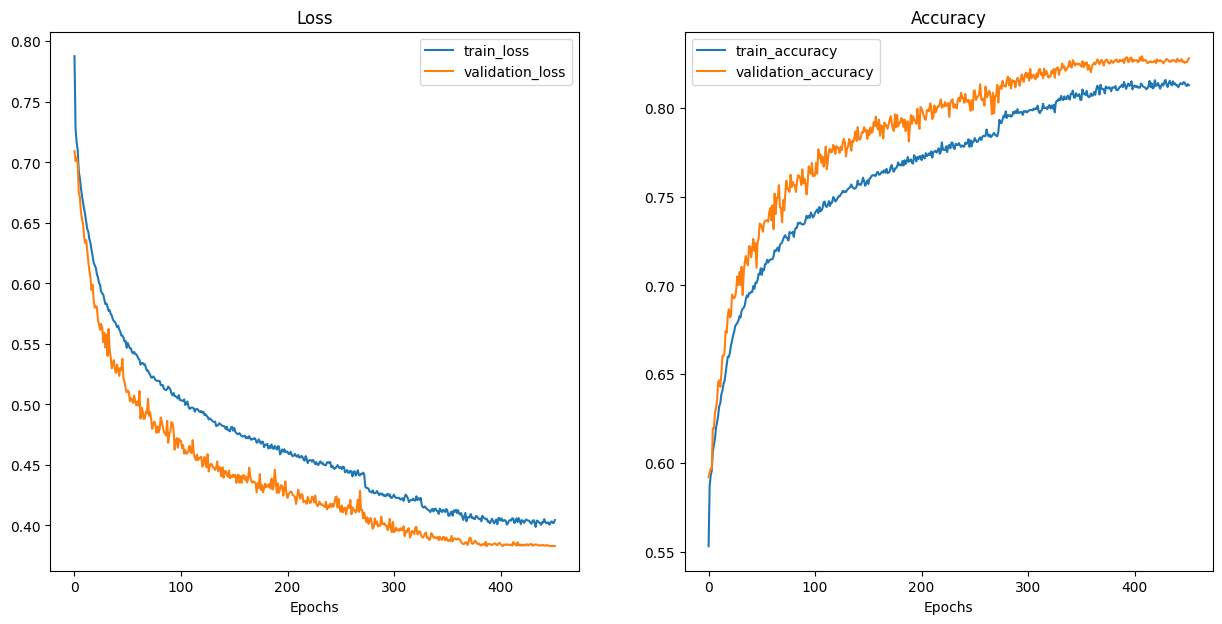

In [4]:
import argparse

training_args = argparse.Namespace(**args)
train_model(training_args, device)